### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде shell скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

> ### Важно: Разделение выборок
> Перед началом выполнения вашего проекта важно правильно подготовить данные, разделив их на подвыборки. Это позволит оценить производительность модели более объективно и управлять риском переобучения. В зависимости от ваших целей и доступных данных, вы можете использовать различные стратегии разделения:

1. Разделение на train/val/test: Это классический подход, где данные делятся на три части. Обучающая выборка (train) используется для первичного обучения моделей, валидационная (val) - для настройки гиперпараметров и выбора лучшей модели, а тестовая (test) - для финальной оценки производительности модели. Такой подход идеален, если у вас достаточно данных, чтобы разделить их и каждая из выборок была репрезентативна.

2. Разделение на train/test с кросс-валидацией на train: Если данных недостаточно для трех подвыборок, можно ограничиться разделением на обучающую и тестовую выборки. В этом случае кросс-валидация на обучающей выборке поможет оценить стабильность модели и подобрать гиперпараметры.

Определение способа разделения данных: Выбор метода разбиения данных на подвыборки — train, validation и test — должен быть обоснован особенностями вашего набора данных и задачами проекта. Возможные методы разделения, включая различные стратегии и правила, подробно описаны в [документации scikit-learn по разбиению данных](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Вы можете следовать этим примерам или разработать собственный метод, исходя из специфики ваших данных.

Ваша задача - выбрать подходящий метод разделения данных исходя из объема и специфики ваших данных. Помните, что финальные метрики качества модели мы будем оценивать на тестовой выборке. Промежуточные результаты после каждого этапа проекта (например, после настройки гиперпараметров) следует оценивать на валидационной выборке, если таковая имеется. Это поможет вам корректно настроить модель перед финальной оценкой её производительности.

In [1]:
! pip install phik geopy

In [2]:
import mlflow
import os
import matplotlib.pyplot as plt
from phik import resources, report
from phik.report import plot_correlation_matrix
from phik import phik_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Dict, Any
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, r2_score
import psycopg2 as psycopg
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from autofeat import AutoFeatRegressor
import numpy as np
from autofeat import AutoFeatRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, SplineTransformer, OneHotEncoder, StandardScaler, OneHotEncoder
from category_encoders import CatBoostEncoder
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import r2_score, mean_absolute_error

plt.style.use('fivethirtyeight')
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "ALEXEY_PROJECT"
RUN_NAME_EDA = 'EDA'

ARTIFACT_DIR = "ARTIFACT_EDA"
DATA_DIR_PATH = '/home/mle-user/mle-pipeline-model-development/data'
CV_RESULTS_PATH = "/home/mle-user/mle-pipeline-model-development/cv_results"
notebook_path = "/home/mle-user/mle-pipeline-model-development/model_improvement/PROJECT.ipynb"
conclusion_path = "/home/mle-user/mle-pipeline-model-development/model_improvement/colclusion_EDA.md"

pd.options.display.max_columns = 70

# устанавливаем соединение с mlflow API
client = mlflow.MlflowClient(tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
                             registry_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# получаем уникальный номер эксперимента по имени
experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

# создание директории для артефактов
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [3]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [4]:
# Функция получения метрик на кросс-валидации и test


def calculate_rmse(predictions: np.ndarray, targets: np.ndarray) -> float:
    return np.sqrt(((predictions - targets) ** 2).mean())

def evaluate_model(model: BaseEstimator, train: np.ndarray,
                   target_train: np.ndarray, test: np.ndarray,
                   target_test: np.ndarray, cv_strategy: Any) -> Dict[str, float]:
    """Расчет метрик на кросс-валидации и test"""

    cv_res = cross_validate(
        model,
        train,
        target_train,
        cv=cv_strategy,
        n_jobs=3,
        scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']
    )

    # Переименовываем ключи
    cv_res_renamed = {f'cv_{key[5:]}': value for key, value in cv_res.items() if key.startswith('test_')}
    # Добавляем остальные ключи без изменений
    cv_res_renamed.update({key: value for key, value in cv_res.items() if not key.startswith('test_')})
    
    # Результаты с кросс-валидации
    for key, value in cv_res_renamed.items():
        if isinstance(value, list) or isinstance(value, np.ndarray):
            cv_res_renamed[key] = round(value.mean(), 3)
        else:
            cv_res_renamed[key] = round(value, 3)

    # Оцениваем модель на тестовом наборе данных
    predictions = model.predict(test)
    cv_res_renamed['test_rmse'] = round(calculate_rmse(predictions, target_test), 3)
    cv_res_renamed['test_r2'] = round(r2_score(target_test, predictions), 3)
    cv_res_renamed['test_mae'] = round(mean_absolute_error(target_test, predictions), 3)

    return cv_res_renamed



In [5]:
# Функция по добавлению оценки и имя модели в df

result_df = pd.DataFrame()

def append_result_to_df(results: Dict[str, float],
                        model_name: str,
                        df: pd.DataFrame) -> pd.DataFrame:
    """Добавляем результаты модели в таблицу"""

    results['model'] = model_name

    # преобразуем словарь в df
    results_df = pd.DataFrame([results])

    # Добавляем результаты в основной DataFrame
    df = pd.concat([df, results_df], ignore_index=True)
    
    print(f'Сравнительная таблица после добавления модели {model_name}')
    print(df)
    
    return df


In [6]:
# На этапе dvc в папке scripts лежат исходники, были залогированые метрики и модель в mlflow. Извлечь их из mlflow, чтобы 
# занести в таблицу для сравнения

# инициализируем client API
client = mlflow.MlflowClient(tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
                             registry_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

result_baseline = client.get_run(run_id='6aee201f20bc4fceaa3a28066ac06a5d').data.params
result_baseline




{'cv_neg_root_mean_squared_error': '-0.257',
 'cv_r2': '0.508',
 'cv_neg_mean_absolute_error': '-0.199',
 'fit_time': '0.779',
 'score_time': '0.022',
 'test_rmse': '0.252',
 'test_r2': '0.335',
 'test_mae': '0.194'}

In [7]:
# Занесем эти данные в таблицу


result_df = append_result_to_df(result_baseline, "baseline_model", result_df)

Сравнительная таблица после добавления модели baseline_model
  cv_neg_root_mean_squared_error  cv_r2 cv_neg_mean_absolute_error fit_time   
0                         -0.257  0.508                     -0.199    0.779  \

  score_time test_rmse test_r2 test_mae           model  
0      0.022     0.252   0.335    0.194  baseline_model  


In [8]:
# Извлекаем данные после этапа с Airflow

load_dotenv()

connection = {"host": os.getenv("DB_DESTINATION_HOST"),
              'port': os.getenv("DB_DESTINATION_PORT"),
              "dbname": os.getenv("DB_DESTINATION_NAME"),
              "user": os.getenv("DB_DESTINATION_USER"),
              "password": os.getenv("DB_DESTINATION_PASSWORD"),
              'sslmode': 'require',
              'target_session_attrs': 'read-write'}

TABLE_NAME = 'clean_dataset_build_price_2'

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f'SELECT * FROM {TABLE_NAME}')
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

data = pd.DataFrame(data, columns=columns)


In [9]:
data

,id,id_build_flat,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,price,build_year
0,1,6220_0,6,55.717113,37.781120,2.64,84,12,true,9,9.90,19.900000,1,false,35.099998,9500000.0,1965
1,2,18012_1,2,55.794849,37.608013,3.00,97,10,true,7,0.00,16.600000,1,false,43.000000,13500000.0,2001
2,3,17821_2,4,55.740040,37.761742,2.70,80,10,true,9,9.00,32.000000,2,false,56.000000,13500000.0,2000
3,5,9293_4,1,55.808807,37.707306,2.60,208,9,true,3,3.00,14.000000,1,false,24.000000,5200000.0,1971
4,6,23964_5,4,55.724728,37.743069,2.70,192,17,true,9,0.00,0.000000,2,false,51.009998,8490104.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107455,141358,22455_141357,4,55.626579,37.313503,2.64,672,25,true,16,11.00,18.000000,1,false,42.000000,10500000.0,2013
107456,141359,3162_141358,1,55.727470,37.768677,2.48,80,5,false,5,5.28,28.330000,2,false,41.110001,7400000.0,1960
107457,141360,6513_141359,4,55.704315,37.506584,2.64,72,9,true,7,5.30,20.000000,1,false,31.500000,9700000.0,1966
107458,141361,23952_141360,4,55.699863,37.939564,2.70,480,25,true,15,13.80,33.700001,2,false,65.300003,11750000.0,2017


In [10]:
# Проведу логарифмирование таргета до разделения выборок

In [11]:
# удалю ненужные столбцы

data = data.drop(['id', 'id_build_flat'], axis=1)

In [12]:
data.dtypes

building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator          object
floor                  int64
kitchen_area         float64
living_area          float64
rooms                  int64
is_apartment          object
total_area           float64
price                 object
build_year             int64
dtype: object

In [13]:
data['price'] = data['price'].astype('float')

2024-05-30 11:07:41,184 INFO: Found credentials in environment variables.


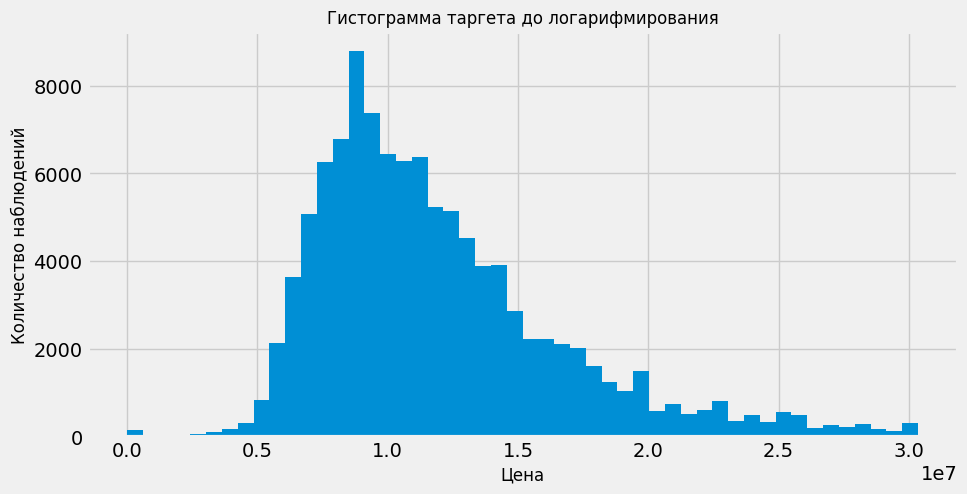

In [14]:
with mlflow.start_run(run_name='target_histplot_before', experiment_id=experiment_id) as run:
    plt.figure(figsize=(10, 5))
    plt.hist(data['price'], bins=50)
    plt.xlabel('Цена')
    plt.ylabel('Количество наблюдений')
    plt.title('Гистограмма таргета до логарифмирования')
    image_path = os.path.join(ARTIFACT_DIR, f"target_histplot_before.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)


In [15]:
# Хорошо подойдет разбиение на train/test с кросс-валидацией

# Прежде чем применять логарифмирование, проверяем, что все значения целевой переменной положительные,
#  так как логарифм от нуля или отрицательного числа не определен

# Почему я применяю логарифмирование таргета:

# 1. Сильный разброс значений таргета: значения таргета варьируются в широком диапазоне, логарифмирование помогает уменьшить этот разброс
# 2. Смещение распределения: логарифмирование может сделать распределение более симметричным


data['price'] = np.log1p(data['price'])


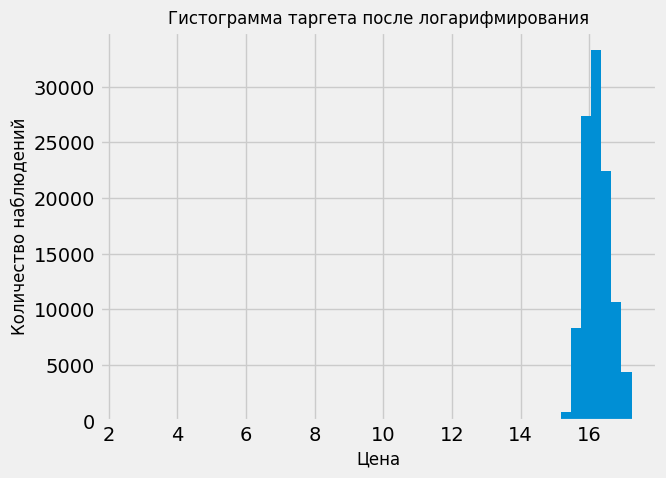

In [16]:
with mlflow.start_run(run_name='target_histplot_after', experiment_id=experiment_id) as run:
    plt.hist(data['price'], bins=50)
    plt.xlabel('Цена')
    plt.ylabel('Количество наблюдений')
    plt.title('Гистограмма таргета после логарифмирования')
    image_path = os.path.join(ARTIFACT_DIR, f"target_histplot_after.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)



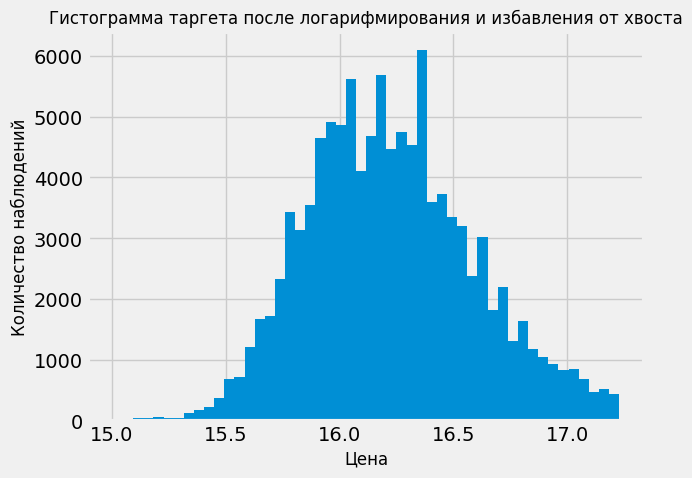

In [17]:
# предлагаю выравнять распрделение и избавиться от хвоста

data = data.query('price >= 15')


with mlflow.start_run(run_name='target_histplot_after_and_tail', experiment_id=experiment_id) as run:
    plt.hist(data['price'], bins=50)
    plt.xlabel('Цена')
    plt.ylabel('Количество наблюдений')
    plt.title('Гистограмма таргета после логарифмирования и избавления от хвоста')
    image_path = os.path.join(ARTIFACT_DIR, f"target_histplot_after_and_tail.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)

In [18]:
data

,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,price,build_year
0,6,55.717113,37.781120,2.64,84,12,true,9,9.90,19.900000,1,false,35.099998,16.066802,1965
1,2,55.794849,37.608013,3.00,97,10,true,7,0.00,16.600000,1,false,43.000000,16.418200,2001
2,4,55.740040,37.761742,2.70,80,10,true,9,9.00,32.000000,2,false,56.000000,16.418200,2000
3,1,55.808807,37.707306,2.60,208,9,true,3,3.00,14.000000,1,false,24.000000,15.464169,1971
4,4,55.724728,37.743069,2.70,192,17,true,9,0.00,0.000000,2,false,51.009998,15.954412,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107455,4,55.626579,37.313503,2.64,672,25,true,16,11.00,18.000000,1,false,42.000000,16.166886,2013
107456,1,55.727470,37.768677,2.48,80,5,false,5,5.28,28.330000,2,false,41.110001,15.816991,1960
107457,4,55.704315,37.506584,2.64,72,9,true,7,5.30,20.000000,1,false,31.500000,16.087637,1966
107458,4,55.699863,37.939564,2.70,480,25,true,15,13.80,33.700001,2,false,65.300003,16.279364,2017


In [19]:
# Разбиваем на выборки, учитывая перемешивание данных для сохранения распределения таргета

train, test = train_test_split(data, shuffle=True, test_size=0.3, random_state=42)

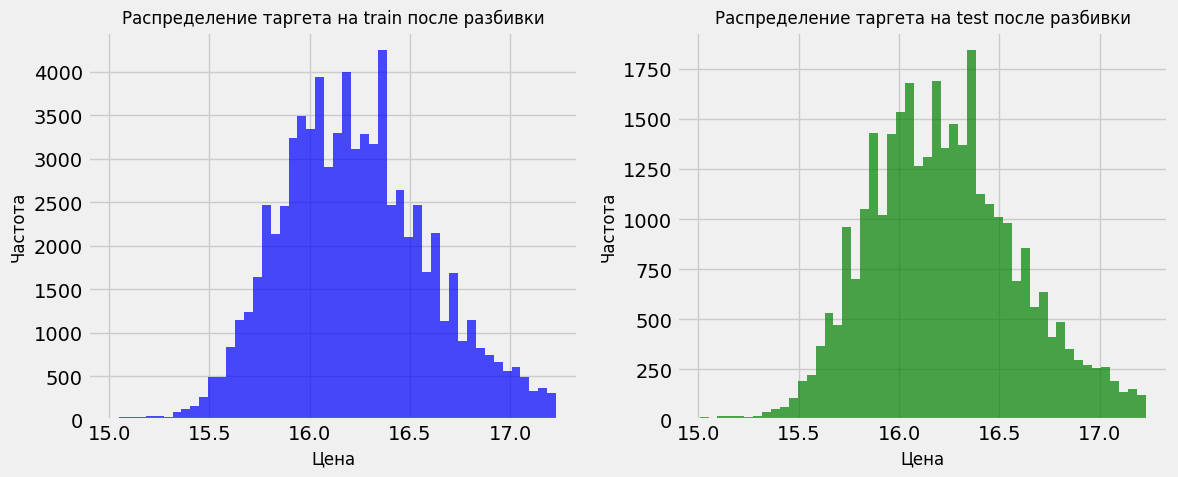

In [20]:
# Сравним распределение таргета на train и test
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].hist(train['price'], bins=50, color='blue', alpha=0.7)
axes[0].set_title('Распределение таргета на train после разбивки', fontsize=12)
axes[0].set_xlabel('Цена', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)

# Гистограмма для test['price']
axes[1].hist(test['price'], bins=50, color='green', alpha=0.7)
axes[1].set_title('Распределение таргета на test после разбивки')
axes[1].set_xlabel('Цена')
axes[1].set_ylabel('Частота')

# Устанавливаем более удобное расположение между подграфиками
plt.tight_layout()


with mlflow.start_run(run_name='target_compare_test_and_train', experiment_id=experiment_id) as run:
    image_path = os.path.join(ARTIFACT_DIR, f"target_compare_test_and_train.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)



In [21]:
# распределение сохранилось

#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


In [22]:
# 2.1 Загрузка данных.
# Выше мы уже провели начальный выгрузку данных из БД и логарифмирование таргета и разделение на выборки
# EDA всегда проводится на train, изучим его подробнее

train

,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,price,build_year
35586,6,55.686104,37.599911,2.70,111,16,true,13,10.0,19.000000,1,false,40.000000,16.077274,1981
92368,4,55.884991,37.592194,2.50,375,12,true,2,6.6,45.200001,3,false,63.000000,16.190416,1977
100646,4,55.604836,37.368309,2.74,324,17,true,12,9.6,18.799999,1,false,41.000000,15.761421,2015
54529,4,55.660862,37.763702,2.64,474,14,true,8,10.0,38.000000,2,false,53.700001,16.296242,1998
64085,4,55.705917,37.931732,2.70,467,19,true,4,4.0,23.000000,1,false,35.000000,15.775605,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54990,6,55.817020,37.826214,2.64,94,14,true,1,9.6,18.299999,1,false,33.799999,15.856731,1973
76993,4,55.580997,37.669308,2.48,428,12,true,4,7.0,34.000000,2,false,48.000000,15.732433,1976
103964,2,55.673782,37.496704,2.70,238,22,true,3,9.6,35.400002,3,false,68.300003,16.810743,2017
860,4,55.676086,37.725918,2.48,105,16,true,10,10.0,20.000000,1,false,36.000000,15.702580,1994


In [23]:
# 2.2. Общий обзор датасета

train.info()

# Видим, что пропусков нет.
# 3 типа object, building_type_int оставим в этом типе, будем применять target_encoding

<class 'pandas.core.frame.DataFrame'>
Index: 75023 entries, 35586 to 15810
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   building_type_int  75023 non-null  int64  
 1   latitude           75023 non-null  float64
 2   longitude          75023 non-null  float64
 3   ceiling_height     75023 non-null  float64
 4   flats_count        75023 non-null  int64  
 5   floors_total       75023 non-null  int64  
 6   has_elevator       75023 non-null  object 
 7   floor              75023 non-null  int64  
 8   kitchen_area       75023 non-null  float64
 9   living_area        75023 non-null  float64
 10  rooms              75023 non-null  int64  
 11  is_apartment       75023 non-null  object 
 12  total_area         75023 non-null  float64
 13  price              75023 non-null  float64
 14  build_year         75023 non-null  int64  
dtypes: float64(7), int64(6), object(2)
memory usage: 9.2+ MB


In [24]:
# Посмотрим распредления признаков

train.describe()



# видим высокий разброс в фиче flats_count, далее подробнее изучим ее распрделение
# В среднем, высота потолка около 2.7м
# Больше всего 2 комнатных квартир
# Средняя площадь квартиры 52м2
# Средний возраст дома 39 лет
# Средняя цена 16.227826 (логарифмированное) -> около 11 миллионов


# Таким образом, общая картина по квартирам такая: чаще всего продают 2 комантные квартиры площадью 52м2,
#  с возрастом дома 39 лет за 11 миллионов в среднем

,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,floor,kitchen_area,living_area,rooms,total_area,price,build_year
count,75023.000000,75023.000000,75023.000000,75023.000000,75023.000000,75023.000000,75023.000000,75023.000000,75023.000000,75023.000000,75023.000000,75023.000000,75023.000000
mean,3.504845,55.729258,37.598059,2.689830,228.608267,13.127734,6.818949,8.161053,27.773320,1.958333,52.135875,16.225721,1984.598470
std,1.412006,0.106089,0.155168,0.132376,140.795211,5.185214,4.607193,3.043954,14.705181,0.824013,16.661365,0.366693,19.574391
min,0.000000,55.418503,37.150566,2.400000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,12.800000,15.004878,1905.000000
25%,2.000000,55.648048,37.492912,2.640000,112.000000,9.000000,3.000000,6.000000,19.000000,1.000000,38.500000,15.955577,1969.000000
50%,4.000000,55.717735,37.589077,2.640000,197.000000,12.000000,6.000000,8.500000,28.700001,2.000000,49.500000,16.204273,1980.000000
75%,4.000000,55.814533,37.719418,2.740000,312.000000,17.000000,10.000000,10.000000,36.700001,3.000000,61.500000,16.454568,2003.000000
max,6.000000,56.011032,37.946411,3.070000,680.000000,30.000000,21.000000,17.139999,78.199997,6.000000,126.900002,17.228307,2023.000000


In [25]:
result = 16.227826
x = np.exp(result) - 1
print(x)

11159770.055869777


In [26]:
# проверим, что в данных нет абсолютных дубликатов

train.drop_duplicates()


,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,price,build_year
35586,6,55.686104,37.599911,2.70,111,16,true,13,10.0,19.000000,1,false,40.000000,16.077274,1981
92368,4,55.884991,37.592194,2.50,375,12,true,2,6.6,45.200001,3,false,63.000000,16.190416,1977
100646,4,55.604836,37.368309,2.74,324,17,true,12,9.6,18.799999,1,false,41.000000,15.761421,2015
54529,4,55.660862,37.763702,2.64,474,14,true,8,10.0,38.000000,2,false,53.700001,16.296242,1998
64085,4,55.705917,37.931732,2.70,467,19,true,4,4.0,23.000000,1,false,35.000000,15.775605,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54990,6,55.817020,37.826214,2.64,94,14,true,1,9.6,18.299999,1,false,33.799999,15.856731,1973
76993,4,55.580997,37.669308,2.48,428,12,true,4,7.0,34.000000,2,false,48.000000,15.732433,1976
103964,2,55.673782,37.496704,2.70,238,22,true,3,9.6,35.400002,3,false,68.300003,16.810743,2017
860,4,55.676086,37.725918,2.48,105,16,true,10,10.0,20.000000,1,false,36.000000,15.702580,1994


In [27]:



# как видим, несколько тысяч записей оказались дубликатами, удалим их
train = train.drop_duplicates()

In [28]:
# ! pip install phik

In [29]:
# 2.3 Анализ признаков для модели

In [30]:
#  Phi_K является обобщением коэффициента корреляции Пирсона и предназначен для более точного измерения ассоциаций в данных,
#  где традиционные методы могут быть неэффективны.

# ### Когда использовать Phi_K (φk)

# 1. **Смешанные типы данных:** Когда у вас есть как числовые, так и категориальные признаки, и вы хотите понять их взаимосвязь.
# 2. **Нелинейные зависимости:** Phi_K может обнаруживать нелинейные зависимости, которые могут быть упущены традиционными методами корреляции.
# 3. **Большое количество уникальных значений:** Если у вас есть категориальные признаки с большим количеством уникальных значений, стандартные методы, такие как коэффициент Cramer’s V, могут быть неэффективны.
# 4. **Неравномерное распределение:** Phi_K хорошо справляется с неравномерно распределенными данными, где частотные методы могут давать искаженные результаты.

In [31]:
train.columns

Index(['building_type_int', 'latitude', 'longitude', 'ceiling_height',
       'flats_count', 'floors_total', 'has_elevator', 'floor', 'kitchen_area',
       'living_area', 'rooms', 'is_apartment', 'total_area', 'price',
       'build_year'],
      dtype='object')

interval columns not set, guessing: ['building_type_int', 'ceiling_height', 'flats_count', 'floors_total', 'floor', 'kitchen_area', 'living_area', 'rooms', 'total_area', 'price', 'build_year']


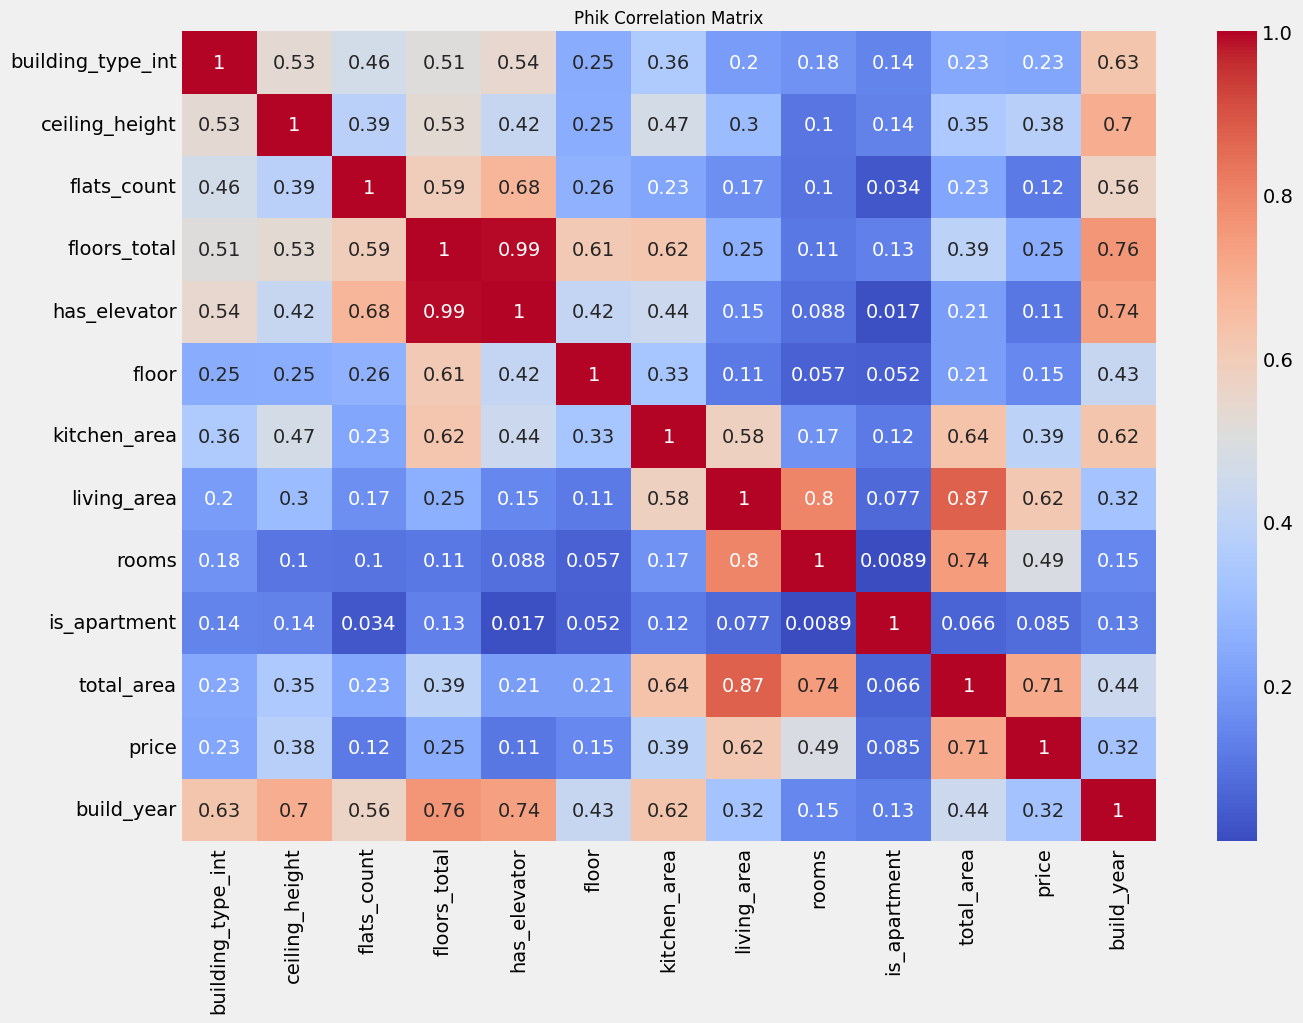

In [32]:
# проведем общий анализ фичей
# Построим корреляционную матрицу


# Вычислим матрицу корреляций phik
phik_matrix = train.drop(['latitude', 'longitude'], axis=1).phik_matrix()


with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:
    plt.figure(figsize=(14, 10))
    sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
    plt.title("Phik Correlation Matrix")
    image_path = os.path.join(ARTIFACT_DIR, f"phik_correlation_matrix.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)


In [33]:


# как видим из heatmap для phik:
# 
# 
# 
# Из интересного сразу видим прямую зависимость между тем, есть ли лифт и количеству этажей!))
# также видим связь между возрастом дома, этажами и лифтом, предположу, что чем старше дом, тем меньше домов были с лифтами

In [34]:
train.columns

Index(['building_type_int', 'latitude', 'longitude', 'ceiling_height',
       'flats_count', 'floors_total', 'has_elevator', 'floor', 'kitchen_area',
       'living_area', 'rooms', 'is_apartment', 'total_area', 'price',
       'build_year'],
      dtype='object')

In [35]:
# интересно посмотреть на связь между высотой потолка и возрастом дома

train['ceiling_height_bin'] = pd.qcut(train['ceiling_height'], q=3)

# Группировка и агрегация
grouped = train.groupby('ceiling_height_bin')['build_year'].agg(['mean', 'count']).reset_index()
grouped



# как видим, в новостройках высота потолков выше и равна 2.7м

,ceiling_height_bin,mean,count
0,"(2.399, 2.64]",1978.557847,46009
1,"(2.64, 2.7]",1992.757978,10090
2,"(2.7, 3.07]",1994.934211,18924


2024-05-30 11:07:54,701 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-30 11:07:54,764 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


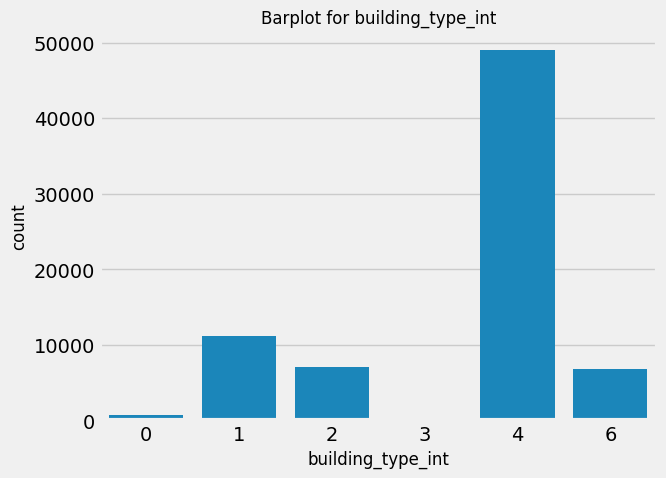

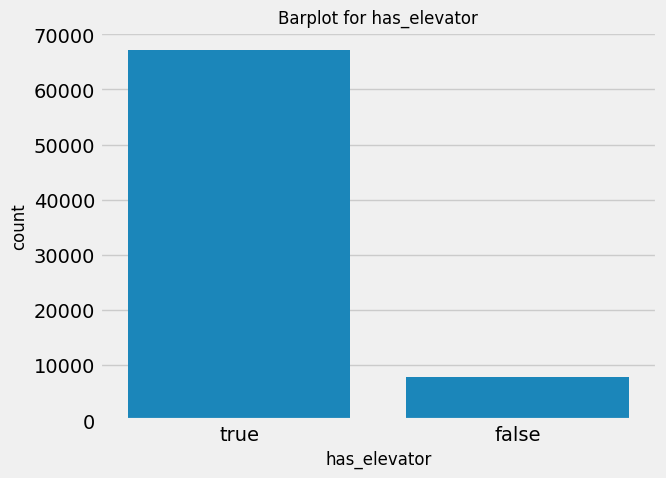

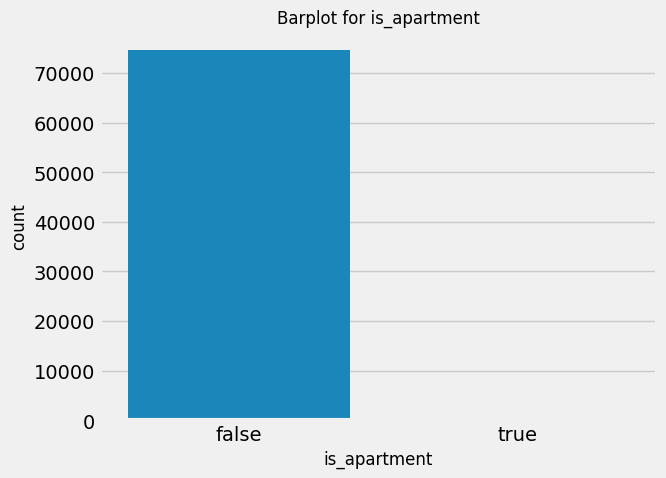

In [36]:
# рассмотрим категориальне фичи по отдельности

categorical_features = ['building_type_int', 'has_elevator', 'is_apartment']

# Построение barplot для категориальных фичей

with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:
    for feature in categorical_features:
        sns.countplot(data=train, x=feature)
        plt.title(f'Barplot for {feature}')
        image_path = os.path.join(ARTIFACT_DIR, f"{feature}_barplot.png")
        plt.savefig(image_path)
        mlflow.log_artifact(image_path)
        plt.show()
        # close закрывает работу с текущим изображением и освобождает память новому
        plt.close()



# Из столбчатых диаграм видно, что преобладает 4 тип строения (хотя нам это ни о чем не говорит, в описании нет данных, стоит запросить у аналитиков)
# В преобладающей части домой в данных присутствует лифт, в старых зданиях он есть не везде
# В данных практически нет апартаментов

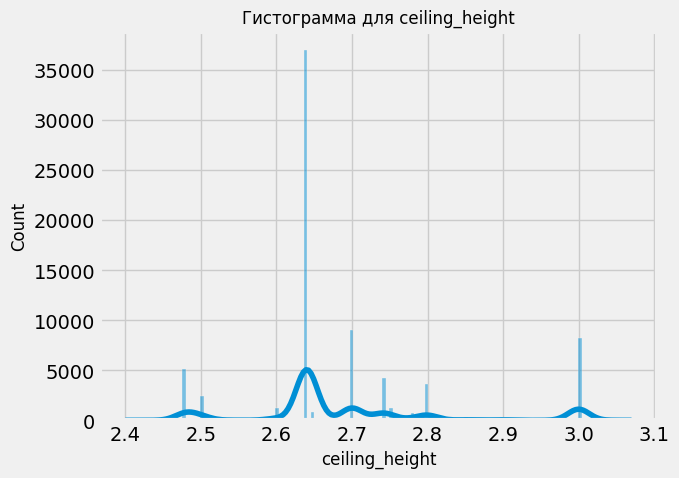

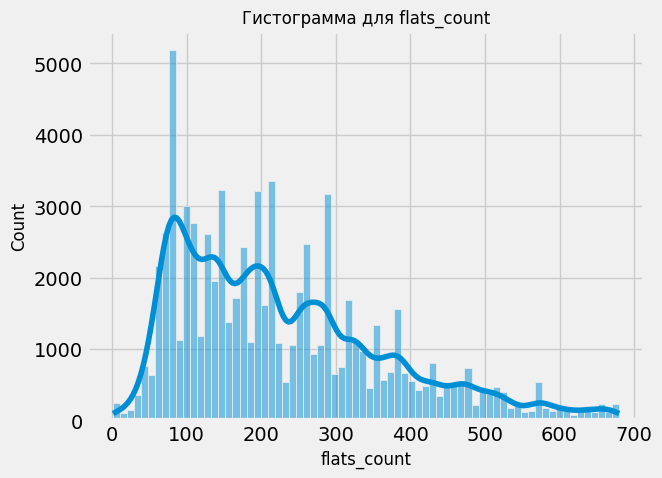

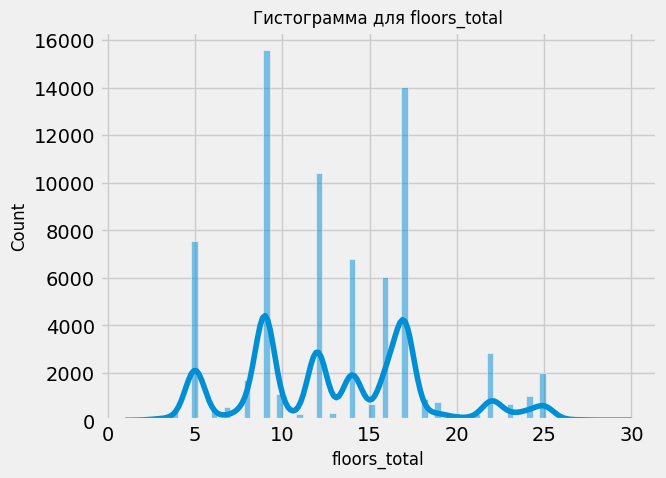

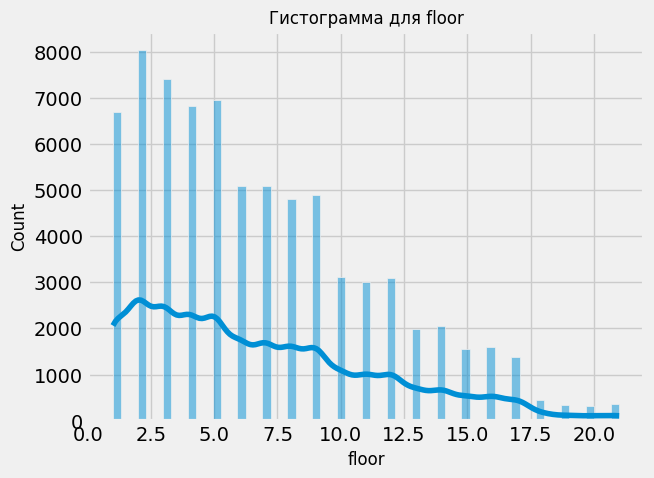

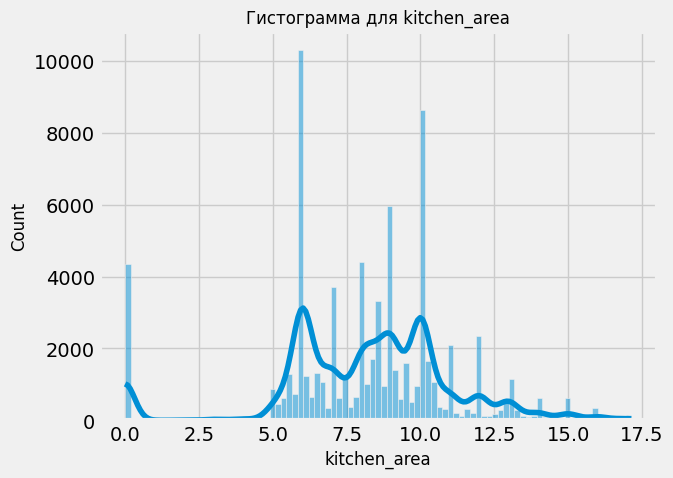

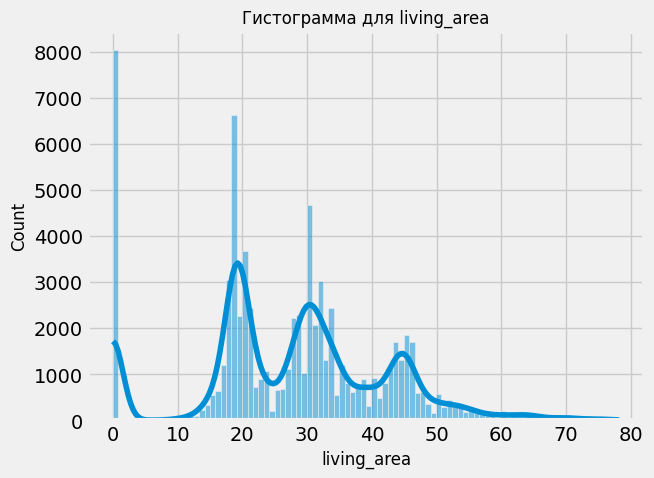

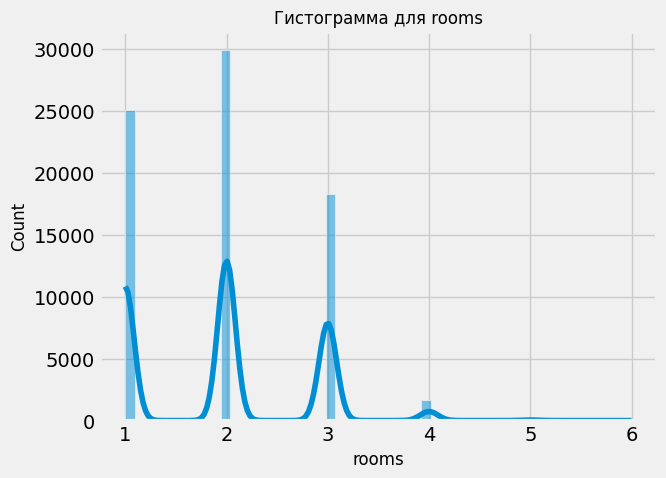

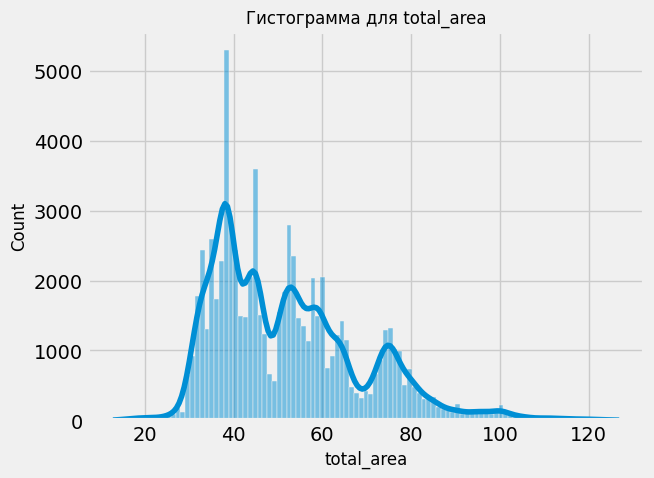

In [37]:
numerical_features = ['ceiling_height', 'flats_count', 'floors_total',
                      'floor', 'kitchen_area', 'living_area', 'rooms',
                      'total_area']
# Построение histplot для числовых значений
with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:
    for feature in numerical_features:
        sns.histplot(data=train, x=feature, kde=True)
        plt.title(f'Гистограмма для {feature}')
        image_path = os.path.join(ARTIFACT_DIR, f"{feature}_histplot.png")
        plt.savefig(image_path)
        mlflow.log_artifact(image_path)
        plt.show()
        # close закрывает работу с текущим изображением и освобождает память новому
        plt.close()


# из интересного - есть наблюдения, где очень маленькие жилая площадь и кухня, предположу, что это студии
# в них они не считаются в расчете.

# так же в высоте потолков видим пик около 2.65, стандартаная высота потолков в домах

# преобладают квартиры от 1 до 3 комнат, самые распространенные варианты

# также в основном дома продают не старше 70 лет, поскольку потом жилье считается аварийным

In [38]:
train.columns

Index(['building_type_int', 'latitude', 'longitude', 'ceiling_height',
       'flats_count', 'floors_total', 'has_elevator', 'floor', 'kitchen_area',
       'living_area', 'rooms', 'is_apartment', 'total_area', 'price',
       'build_year', 'ceiling_height_bin'],
      dtype='object')

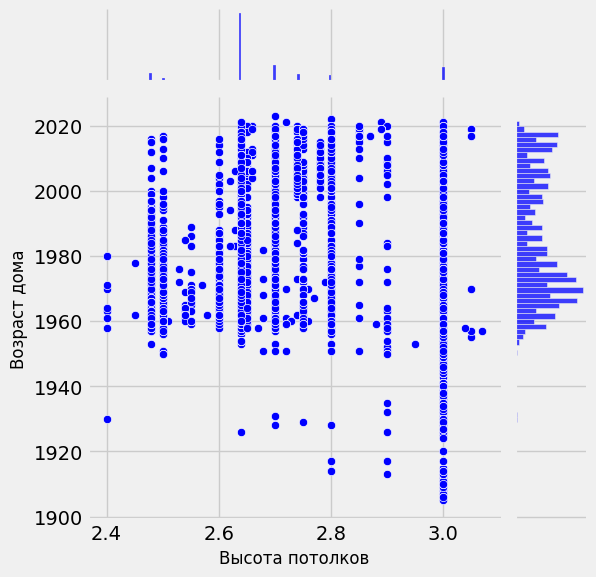

In [39]:
# Построение scatterplot для некоторых фичей
scatter_features = ['ceiling_height', 'build_year']  # замените на названия ваших фичей

x = train['ceiling_height']
y = train['build_year']

with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:
    sns.jointplot(x=x, y=y, kind='scatter', color='blue')
    plt.xlabel('Высота потолков')
    plt.ylabel('Возраст дома')
    image_path = os.path.join(ARTIFACT_DIR, f"ceiling_height_house_age_jointplot.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)
    plt.show()


# Можем заметить, что очень высокие потолки встречаются в старых домах

In [40]:
# 2.4 Анализ целевой переменной

<Axes: ylabel='Frequency'>

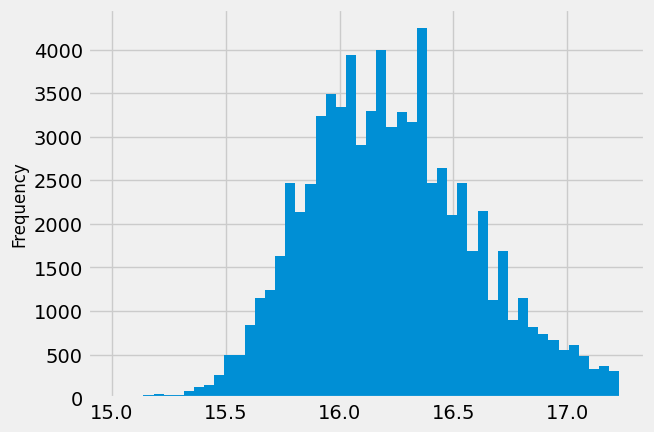

In [41]:
# После логарифмирования распредление целевой переменной выглядит так

train['price'].plot.hist(bins=50)

# Распределение имеет небольшой хвост слева. Благодаря лагорифмированию мы избавились от огромного диапазона значений

In [42]:
# 2.4 Анализ целевой переменной в зависимости от различных признаков

In [43]:
# По анализу phik можем сказать, что особое влияние на цену квартиры оказывают:
# общая площадь квартиры
# количество комнат
# жилая площадь
# площадь кухни
# высота потолков

# 5 этих фичи показывают наибольшую зависимость с таргетом

In [44]:
# построим 5 сводных таблиц, чтобы оценить влияние этих признаков на цену
# но для начала эти числовые значения нужно разбить на интервалы



In [45]:
train.columns

Index(['building_type_int', 'latitude', 'longitude', 'ceiling_height',
       'flats_count', 'floors_total', 'has_elevator', 'floor', 'kitchen_area',
       'living_area', 'rooms', 'is_apartment', 'total_area', 'price',
       'build_year', 'ceiling_height_bin'],
      dtype='object')

In [46]:
# сначала рассмотрим зависимость цены от общей площади, разобьем с помощью qcut

train['total_area_bin'] = pd.qcut(train['total_area'], q=4)

# Группировка и агрегация
grouped = train.groupby('total_area_bin')['price'].agg(['mean', 'count']).reset_index()
grouped

# как видим, чем больше общая площадь, тем больше цена, логично)


,total_area_bin,mean,count
0,"(12.799000000000001, 38.5]",15.937350,18869
1,"(38.5, 49.5]",16.082481,18651
2,"(49.5, 61.5]",16.316249,18802
3,"(61.5, 126.9]",16.568522,18701


In [47]:
# для комнат, площади кухни аналогично, а вот проверим высоту потолков

train['ceiling_height_bin'] = pd.qcut(train['ceiling_height'], q=3)

# Группировка и агрегация
grouped = train.groupby('ceiling_height_bin')['price'].agg(['mean', 'count']).reset_index()
grouped

# как видим, цена выше там, где больше высота потолков

,ceiling_height_bin,mean,count
0,"(2.399, 2.64]",16.153935,46009
1,"(2.64, 2.7]",16.254452,10090
2,"(2.7, 3.07]",16.384933,18924


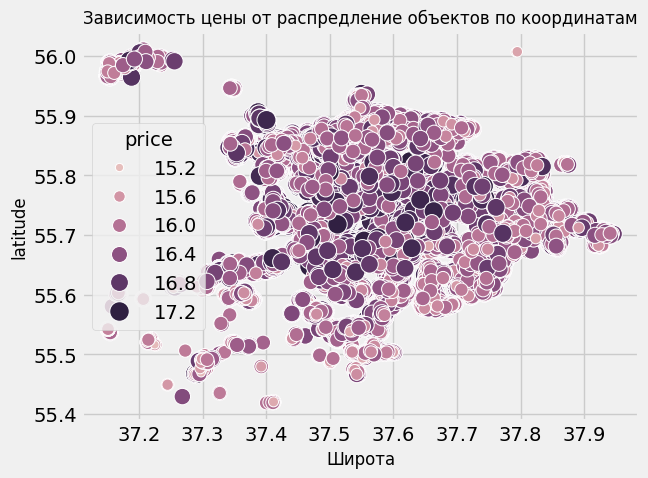

In [48]:
# Построим график зависимости координат от цены

plt.figsize=(12, 8)

sns.scatterplot(data=train, x='longitude', y='latitude', hue='price', size='price', sizes=(20, 200))
plt.xlabel('Долгота')
plt.xlabel('Широта')
plt.title('Зависимость цены от распредление объектов по координатам')


# Как видим, в центре Питера цены выше


with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:
    image_path = os.path.join(ARTIFACT_DIR, f"price_compare_longtitude_latitude.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)
    plt.show()


In [49]:
train.columns

Index(['building_type_int', 'latitude', 'longitude', 'ceiling_height',
       'flats_count', 'floors_total', 'has_elevator', 'floor', 'kitchen_area',
       'living_area', 'rooms', 'is_apartment', 'total_area', 'price',
       'build_year', 'ceiling_height_bin', 'total_area_bin'],
      dtype='object')

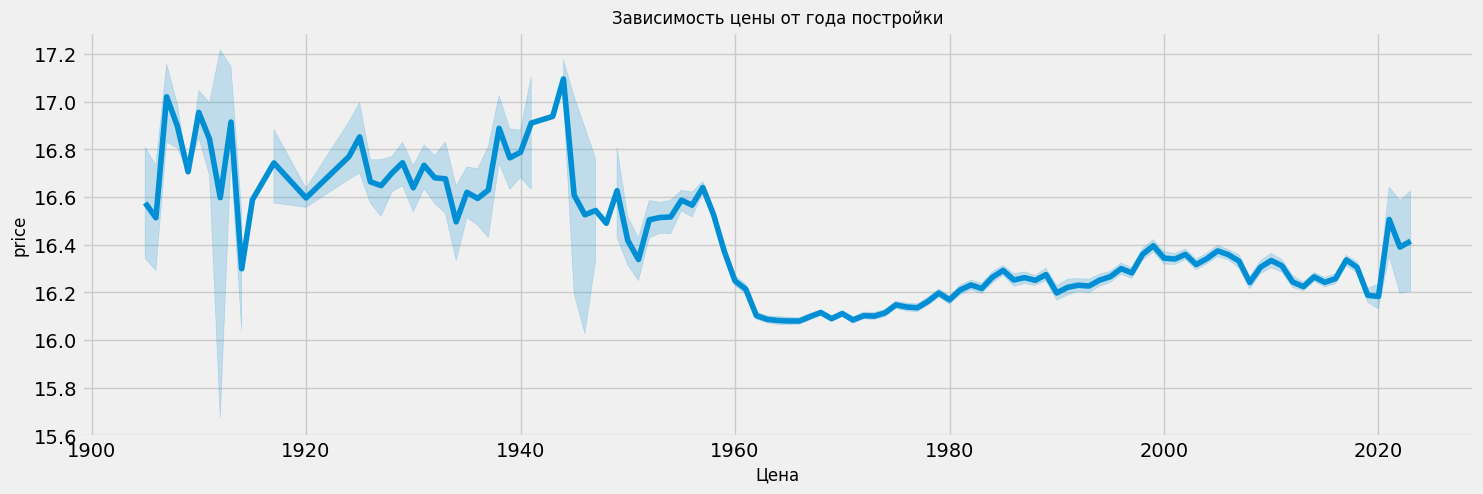

In [50]:
plt.figure(figsize=(16, 5))
sns.lineplot(train, x='build_year', y='price')
plt.xlabel('Год постройки')
plt.xlabel('Цена')
plt.title('Зависимость цены от года постройки')


# Как видим, есть старые дорогие дома, возможно какие-то раритетные) А ценообразование новых домов зависит от года постройки, видно
# Что чем новее дом (не из раритетных), тем его цена выше.


with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:
    image_path = os.path.join(ARTIFACT_DIR, f"year_price.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)
    plt.show()

# 2.5 Выводы после EDA

Видим, что пропусков в данных нет, значит этап с Airflow отработал корректно. Удалил дубликаты из датасета, это улучшит обобщаю способность модели.



Имеем типа object: из которого признак building_type_int оставим в этом типе, к нему будем применять target_encoding. Что означает этот признак
с его значениями непонятно, стоит обратиться к аналитикам за объяснениями.



Проведя статистический анализ фичей приходим к таким выводам:
* видим высокий разброс в фиче flats_count.
* В среднем, высота потолка около 2.7м
* Больше всего 2 комнатных квартир
* Средняя площадь квартиры 52м2
* Средний возраст дома 39 лет
* Средняя цена 16.227826 (логарифмированное) -> около 11 миллионов



Таким образом, **общая картина по квартирам такая**: чаще всего продают 2 комантные квартиры площадью 52м2, с возрастом дома 39 лет за 11 миллионов в среднем.



Из столбчатых диаграм видно, что преобладает 4 тип строения (хотя нам это ни о чем не говорит, в описании нет данных, стоит запросить у аналитиков)
В преобладающей части домой в данных присутствует лифт, в старых зданиях он есть не везде
В данных практически нет апартаментов.



Из интересного в гистограммах - есть наблюдения, где очень маленькие жилая площадь и кухня, предположу, что это студии.
Так же в высоте потолков видим пик около 2.65, стандартаная высота потолков в домах.
Преобладают квартиры от 1 до 3 комнат, самые распространенные варианты
также в основном дома продают не старше 70 лет, поскольку потом жилье считается аварийным



По jointpltot Можем заметить, что очень высокие потолки встречаются в старых домах.


Проведя анализ с помощью phik можем сказать следующее:
Из интересного сразу видим прямую зависимость между тем, есть ли лифт и количеству этажей!))
также видим связь между возрастом дома, этажами и лифтом, предположу, что чем старше дом, тем меньше домов были с лифтами
как видим, в новостройках высота потолков выше и равна 2.7м

По анализу phik можем сказать, **что особое влияние на цену квартиры оказывают:**
* общая площадь квартиры
* количество комнат
* жилая площадь
* площадь кухни
* высота потолков

Как видим, есть старые дорогие дома, возможно какие-то раритетные) А ценообразование новых домов зависит от года постройки, видно что чем новее дом (не из раритетных), тем его цена выше.

Как видим, чем больше общая площадь, тем больше цена, логично) для комнат, площади кухни аналогично. Цена также выше там, где больше высота потолков. Возможно, элитное жилье. Также цена объектов в центре выше!

**Распределение целевой переменной имеет небольшой хвост слева. Благодаря логарифмированию мы избавились от огромного диапазона значений!**


In [51]:
# 2.6 логирование артефактов в MLflow

In [52]:
# создание нового запуска для логирования файлов

with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME_EDA) as run:
    local_conclusion_path = os.path.join(ARTIFACT_DIR, "conclusion_EDA.md")
    os.system(f"cp {conclusion_path} {local_conclusion_path}")
    # Логирование файла conclusion_EDA.md
    mlflow.log_artifact(local_conclusion_path)

    # Копирование Jupyter Notebook в директорию артефактов
    local_notebook_path = os.path.join(ARTIFACT_DIR, "PROJECT.ipynb")
    os.system(f"cp {notebook_path} {local_notebook_path}")
    # Логирование Jupyter Notebook
    mlflow.log_artifact(local_notebook_path)
    print("Артефакты успешно зарегистрированы в mlflow и сохранены локально в папку ARTIFACT_EDA.")



Артефакты успешно зарегистрированы в mlflow и сохранены локально в папку ARTIFACT_EDA.


#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.
Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


In [53]:
# признаки, которые я разбивал по квантилям в датасете имеют тип category, учту это, чтобы в select_dtypes они не попали
train.dtypes

building_type_int        int64
latitude               float64
longitude              float64
ceiling_height         float64
flats_count              int64
floors_total             int64
has_elevator            object
floor                    int64
kitchen_area           float64
living_area            float64
rooms                    int64
is_apartment            object
total_area             float64
price                  float64
build_year               int64
ceiling_height_bin    category
total_area_bin        category
dtype: object

In [54]:
train.values[0]

array([6, 55.68610382080078, 37.599910736083984, 2.700000047683716, 111,
       16, 'true', 13, 10.0, 19.0, 1, 'false', 40.0, 16.077273760604726,
       1981, Interval(2.64, 2.7, closed='right'),
       Interval(38.5, 49.5, closed='right')], dtype=object)

In [55]:
train.dtypes

building_type_int        int64
latitude               float64
longitude              float64
ceiling_height         float64
flats_count              int64
floors_total             int64
has_elevator            object
floor                    int64
kitchen_area           float64
living_area            float64
rooms                    int64
is_apartment            object
total_area             float64
price                  float64
build_year               int64
ceiling_height_bin    category
total_area_bin        category
dtype: object

**Масштабирование и другие преобразования не стоит делать до создания новых фичей, поскольку так мы можем получить новый объекты, которые будет сложнее интерпретировать или которые станут менее значимыми, поскольку преобразование масштабирования/... может изменить отношения между переменными.**

Для sklearn Feature Engineering буду использовать фичи:
* kitchen_area
* living_area
* total_area
* house_age
* ceiling_height

Для них использую PolynomialFeatures, KBinsDiscretizer и SplineTransformer


Если у нас есть 5 исходных признаков: kitchen_area, living_area, total_area, и house_age, ceiling_height то полиномиальные признаки второй степени будут включать:
- Все исходные признаки (1 степень): kitchen_area, living_area, total_area, house_age, ceiling_height
- Квадраты каждого признака (2 степень): kitchen_area^2, living_area^2, total_area^2, house_age^2, ceiling_height^2
- Все возможные пары взаимодействий (произведения признаков): kitchen_area \* living_area, kitchen_area \* total_area, и т.д.


KBinsDiscretizer делит каждый числовой признак на несколько интервалов (бинов). В вашем случае используется параметр n_bins=5, что означает деление каждого признака на 5 бинов. То есть, число фичей будет 5
Таким образом, будет создано 4 новых признака:
- kbins_kitchen_area
- kbins_living_area
- kbins_total_area
- kbins_house_age
- kbins_ceiling_height


SplineTransformer создает сплайн-признаки для каждого числового признака. В вашем случае используется параметр n_knots=3, что означает создание 3 узлов (knots). По умолчанию, это приводит к созданию ( n_knots + degree - 1) новых признаков для каждого исходного признака (где degree по умолчанию равен 3). Значит у нас создастся 6 новых фичей для каждого признака)



In [56]:
# Выделение признаков для предобработки, которые учитываться не будут
train = train.drop(['ceiling_height_bin', 'total_area_bin'], axis=1)


In [57]:
# 3.1 ручная генерация признаков


In [58]:
# cгенерирую признак возраста дома. Сразу его сделаю и для test
train['house_age'] = 2024 - train['build_year']
test['house_age'] = 2024 - test['build_year']

train = train.drop(['build_year'], axis=1)
test = test.drop(['build_year'], axis=1)

In [59]:
# У нас есть координаты объектов, на основании этого можно создать признак расстояня до цента Питера
# Используем geopy
# За координаты центра возьмем Центр Невского проспекта

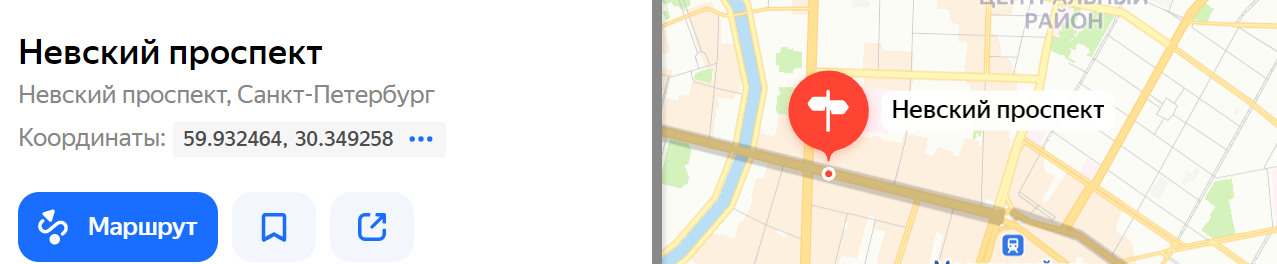

In [60]:
from geopy.distance import geodesic

center_coords = (59.932464, 30.349258)

def calculate_distance(row: pd.Series) -> float:
    """Расчет километража от объекта до центра Питера"""
    point_coords = (row['latitude'], row['longitude'])
    return geodesic(point_coords, center_coords).kilometers


In [61]:
# Создаем признак километража до центра

train['distance_to_center'] = train.apply(calculate_distance, axis=1)

In [62]:
test['distance_to_center'] = test.apply(calculate_distance, axis=1)

In [63]:
# Удалим широту и долготу из датафреймов

train = train.drop(['latitude', 'longitude'], axis=1)
test = test.drop(['latitude', 'longitude'], axis=1)

In [64]:
# 3.2 Feature Engineering c sklearn

In [65]:
train

,building_type_int,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,price,house_age,distance_to_center
35586,6,2.70,111,16,true,13,10.0,19.000000,1,false,40.000000,16.077274,43,639.175761
92368,4,2.50,375,12,true,2,6.6,45.200001,3,false,63.000000,16.190416,47,621.888198
100646,4,2.74,324,17,true,12,9.6,18.799999,1,false,41.000000,15.761421,9,637.133726
54529,4,2.64,474,14,true,8,10.0,38.000000,2,false,53.700001,16.296242,26,647.902058
64085,4,2.70,467,19,true,4,4.0,23.000000,1,false,35.000000,15.775605,9,650.884593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54990,6,2.64,94,14,true,1,9.6,18.299999,1,false,33.799999,15.856731,51,637.190423
76993,4,2.48,428,12,true,4,7.0,34.000000,2,false,48.000000,15.732433,48,651.012715
103964,2,2.70,238,22,true,3,9.6,35.400002,3,false,68.300003,16.810743,7,636.145983
860,4,2.48,105,16,true,10,10.0,20.000000,1,false,36.000000,15.702580,30,645.078986


In [66]:
# Используем FE для создания новых признаков
# Для них использую PolynomialFeatures, KBinsDiscretizer и SplineTransformer

poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
kbins_transformer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
spline_transformer = SplineTransformer(n_knots=3, degree=3)


catboost_category_encoder = CatBoostEncoder(return_df=False)
ohe_encoder = OneHotEncoder(drop='if_binary')



In [67]:
# 3.3 автоматическая генерация признаков

**При feateng_steps=1 новые фичи для столбцов не генерировались, решение оказалось повышение числа итераций алгоритма. Более высокий параметр feateng_steps позволяет алгоритму выполнять более глубокий анализ и создавать более сложные признаки.**

**Теперь изменю подход и для каждых колонок данных выберу свой Transform**

In [68]:

feature_for_autofeat = ['kitchen_area',
                        'living_area',
                        'total_area',
                        'house_age',
                        'ceiling_height']

feature_for_kbins_transformer = ['house_age', 'ceiling_height']
feature_for_poly_spline_transformer = ['kitchen_area', 'living_area', 'total_area', 'ceiling_height']

feature_for_OHE = ['is_apartment', 'has_elevator']
feature_for_target_encoding = ['building_type_int', 'rooms']

feature_tail_scaler = ['flats_count', 'floors_total', 'floor', 'distance_to_center']

poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
kbins_transformer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
spline_transformer = SplineTransformer(n_knots=3, degree=3)


catboost_category_encoder = CatBoostEncoder(return_df=False)
ohe_encoder = OneHotEncoder(drop='if_binary')



afc = AutoFeatRegressor(feateng_cols=feature_for_autofeat,
                        feateng_steps=2,
                        max_gb=2,
                        transformations=['1/', 'log', 'abs', 'sqrt'],
                        n_jobs=1)



poly_scaler_pipeline = Pipeline(steps=[
    ('poly_spline_auto', poly_transformer),
    ('scaler', StandardScaler())
])


spline_scaler_pipeline = Pipeline(steps=[
    ('spline_spline_auto', spline_transformer),
    ('scaler', StandardScaler())
])

# переопределили класс transformer
class AutoFeatWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, feateng_cols, feateng_steps=2, max_gb=2, transformations=['1/', 'log', 'abs', 'sqrt'], n_jobs=1):
        self.feateng_cols = feateng_cols
        self.feateng_steps = feateng_steps
        self.max_gb = max_gb
        self.transformations = transformations
        self.n_jobs = n_jobs
        self.afc = AutoFeatRegressor(feateng_cols=self.feateng_cols,
                                     feateng_steps=self.feateng_steps,
                                     max_gb=self.max_gb,
                                     transformations=self.transformations,
                                     n_jobs=self.n_jobs)
        
    def fit(self, X, y=None):
        self.afc.fit(X, y)
        return self
    
    def transform(self, X):
        return self.afc.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        # Преобразуем данные и возвращаем имена фичей из DataFrame
        transformed_X = self.afc.transform(pd.DataFrame(np.zeros((1, len(self.feateng_cols))), columns=self.feateng_cols))
        return transformed_X.columns.tolist()

# Используем новый обертчик в вашем пайплайне

autofeat_scaler_pipeline = Pipeline(steps=[
    ('autofeat_spline_auto', AutoFeatWrapper(feateng_cols=feature_for_autofeat)),
    ('scaler', StandardScaler())
])


tail_scaler_pipeline = Pipeline(steps=[
    ('tail_feature_scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('poly', poly_scaler_pipeline, feature_for_poly_spline_transformer),
    ('spline', spline_scaler_pipeline, feature_for_poly_spline_transformer),
    ('afc', autofeat_scaler_pipeline, feature_for_autofeat),
    ('tail_scaler', tail_scaler_pipeline, feature_tail_scaler),
    ('category_encoder', catboost_category_encoder, feature_for_target_encoding),
    ('ohe', ohe_encoder, feature_for_OHE),
    ('kbins', kbins_transformer, feature_for_kbins_transformer)
],  remainder='passthrough',
    verbose_feature_names_out=True )


preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('poly',
                                 Pipeline(steps=[('poly_spline_auto',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['kitchen_area', 'living_area', 'total_area',
                                  'ceiling_height']),
                                ('spline',
                                 Pipeline(steps=[('spline_spline_auto',
                                                  SplineTransformer(n_knots=3)),
                                                 ('scaler', StandardScaler())]),
                                 ['kitchen_...
                                 Pipeline(steps=[('tail_feature_scaler',
                                                  StandardScaler())]),
                                 ['flats_count', 'floors_total', 'floor',
                                  'distance_to_center']),
                                ('category_encoder',
                                 CatBoostEncoder(return_df=False),
                                 ['building_type_int', 'rooms']),
                                ('ohe', OneHotEncoder(drop='if_binary'),
                                 ['is_apartment', 'has_elevator']),
                                ('kbins',
                                 KBinsDiscretizer(encode='ordinal',
                                                  strategy='uniform'),
                                 ['house_age', 'ceiling_height'])])

In [69]:
preprocessor.fit(train, train['price'])


/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('poly',
                                 Pipeline(steps=[('poly_spline_auto',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['kitchen_area', 'living_area', 'total_area',
                                  'ceiling_height']),
                                ('spline',
                                 Pipeline(steps=[('spline_spline_auto',
                                                  SplineTransformer(n_knots=3)),
                                                 ('scaler', StandardScaler())]),
                                 ['kitchen_...
                                 Pipeline(steps=[('tail_feature_scaler',
                                                  StandardScaler())]),
                                 ['flats_count', 'floors_total', 'floor',
                                  'distance_to_center']),
                                ('category_encoder',
                                 CatBoostEncoder(return_df=False),
                                 ['building_type_int', 'rooms']),
                                ('ohe', OneHotEncoder(drop='if_binary'),
                                 ['is_apartment', 'has_elevator']),
                                ('kbins',
                                 KBinsDiscretizer(encode='ordinal',
                                                  strategy='uniform'),
                                 ['house_age', 'ceiling_height'])])

In [70]:
train_after_fe = pd.DataFrame(preprocessor.transform(train), columns=preprocessor.get_feature_names_out())

In [71]:
train_after_fe

,poly__kitchen_area,poly__living_area,poly__total_area,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area ceiling_height,poly__total_area^2,poly__total_area ceiling_height,poly__ceiling_height^2,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,afc__kitchen_area,afc__living_area,afc__total_area,afc__house_age,afc__ceiling_height,afc__1/house_age,afc__house_age/total_area,afc__house_age*total_area,afc__living_area/house_age,afc__house_age*living_area,afc__living_area/total_area,afc__kitchen_area/house_age,afc__house_age*kitchen_area,afc__kitchen_area/total_area,afc__kitchen_area*total_area,afc__kitchen_area*living_area,afc__total_area*log(house_age),afc__kitchen_area*log(house_age),afc__sqrt(living_area)/total_area,afc__ceiling_height*log(total_area),afc__log(total_area)/ceiling_height,afc__log(ceiling_height)/ceiling_height,tail_scaler__flats_count,tail_scaler__floors_total,tail_scaler__floor,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__is_apartment_true,ohe__has_elevator_true,kbins__house_age,kbins__ceiling_height,remainder__price
0,0.604135,-0.596618,-0.728389,0.076830,0.509595,-0.304977,-0.158643,0.578627,-0.710115,-0.634057,-0.579869,-0.689013,-0.685270,0.050979,-0.287087,-0.754882,0.458936,0.546145,-0.209269,-0.062781,0.765381,-0.358154,-0.695527,-0.170490,0.484522,0.792940,-0.689016,-0.626947,-0.142357,-0.439541,-0.378547,0.832844,-0.161329,-0.360336,0.604135,-0.596618,-0.728389,0.183837,0.076830,-0.443960,0.405114,-0.228604,-0.495174,-0.340165,-0.263419,-0.292700,0.819429,1.279637,-0.158643,-0.304977,-0.471999,1.028939,0.296464,-0.510048,-0.755627,0.713079,-0.835320,0.553938,1.341618,0.328620,6.0,1.0,0.0,1.0,1.0,2.0,16.077274
1,-0.512841,1.185079,0.652059,-1.434031,-0.682262,0.341250,-0.098742,-0.642461,1.196121,0.926627,0.937263,0.480448,0.347448,-1.370664,-0.234815,0.526513,0.290373,-0.761603,-0.261068,-0.515847,-1.314718,0.814145,1.238901,-0.103227,-0.861592,-0.822217,1.181185,0.281035,-0.142357,2.383102,1.909024,-1.538849,-0.790919,-0.360336,-0.512841,1.185079,0.652059,0.388187,-1.434031,-0.493798,-0.208011,0.866173,-0.102226,1.222866,0.957037,-0.496608,0.072193,-0.925045,-0.098742,0.341250,1.034233,-0.240654,0.235797,-0.146185,1.747029,-1.483043,1.039756,-0.217492,-1.045969,-1.203704,4.0,3.0,0.0,1.0,1.0,0.0,16.190416
2,0.472726,-0.610219,-0.668370,0.379002,0.344036,-0.361772,-0.182906,0.497686,-0.718682,-0.625983,-0.574656,-0.649028,-0.594725,0.348430,-0.287087,-0.648144,0.553681,0.344727,-0.241712,-0.049121,0.782293,-0.379977,-0.700429,-0.170490,0.352115,0.725838,-0.579181,-0.607298,-0.142357,-0.448897,-0.780377,0.910515,0.136600,-0.360315,0.472726,-0.610219,-0.668370,-1.553138,0.379002,1.768299,-1.189328,-1.420420,0.749813,-1.114627,-0.346289,1.553350,-1.323728,1.038982,-0.182906,-0.361772,-1.459053,-0.689929,0.209930,-0.313226,-0.849655,0.707936,0.677526,0.746795,1.124565,0.147619,4.0,1.0,0.0,1.0,0.0,2.0,15.761421
3,0.604135,0.695452,0.093878,-0.376428,0.509595,0.828545,0.360753,0.508851,0.517236,0.323316,0.625477,-0.055317,0.019232,-0.386996,-0.287087,-0.754882,0.458936,0.546145,-0.209269,-0.515773,-0.880577,0.960163,0.402597,-0.170490,-0.662261,-0.178066,0.633362,-0.214752,-0.142357,-0.261803,0.328610,0.382739,-0.480386,-0.360336,0.604135,0.695452,0.093878,-0.684651,-0.376428,-0.061069,-0.696061,-0.514252,0.275600,-0.135730,0.907580,0.043833,-0.240922,0

In [72]:
# 3.4 обучение новой версии модели

In [73]:
train

,building_type_int,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,price,house_age,distance_to_center
35586,6,2.70,111,16,true,13,10.0,19.000000,1,false,40.000000,16.077274,43,639.175761
92368,4,2.50,375,12,true,2,6.6,45.200001,3,false,63.000000,16.190416,47,621.888198
100646,4,2.74,324,17,true,12,9.6,18.799999,1,false,41.000000,15.761421,9,637.133726
54529,4,2.64,474,14,true,8,10.0,38.000000,2,false,53.700001,16.296242,26,647.902058
64085,4,2.70,467,19,true,4,4.0,23.000000,1,false,35.000000,15.775605,9,650.884593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54990,6,2.64,94,14,true,1,9.6,18.299999,1,false,33.799999,15.856731,51,637.190423
76993,4,2.48,428,12,true,4,7.0,34.000000,2,false,48.000000,15.732433,48,651.012715
103964,2,2.70,238,22,true,3,9.6,35.400002,3,false,68.300003,16.810743,7,636.145983
860,4,2.48,105,16,true,10,10.0,20.000000,1,false,36.000000,15.702580,30,645.078986


In [74]:
train['price']

35586     16.077274
92368     16.190416
100646    15.761421
54529     16.296242
64085     15.775605
            ...    
54990     15.856731
76993     15.732433
103964    16.810743
860       15.702580
15810     16.775616
Name: price, Length: 75023, dtype: float64

In [75]:
pd.DataFrame(preprocessor.transform(train), columns=preprocessor.get_feature_names_out())

,poly__kitchen_area,poly__living_area,poly__total_area,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area ceiling_height,poly__total_area^2,poly__total_area ceiling_height,poly__ceiling_height^2,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,afc__kitchen_area,afc__living_area,afc__total_area,afc__house_age,afc__ceiling_height,afc__1/house_age,afc__house_age/total_area,afc__house_age*total_area,afc__living_area/house_age,afc__house_age*living_area,afc__living_area/total_area,afc__kitchen_area/house_age,afc__house_age*kitchen_area,afc__kitchen_area/total_area,afc__kitchen_area*total_area,afc__kitchen_area*living_area,afc__total_area*log(house_age),afc__kitchen_area*log(house_age),afc__sqrt(living_area)/total_area,afc__ceiling_height*log(total_area),afc__log(total_area)/ceiling_height,afc__log(ceiling_height)/ceiling_height,tail_scaler__flats_count,tail_scaler__floors_total,tail_scaler__floor,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__is_apartment_true,ohe__has_elevator_true,kbins__house_age,kbins__ceiling_height,remainder__price
0,0.604135,-0.596618,-0.728389,0.076830,0.509595,-0.304977,-0.158643,0.578627,-0.710115,-0.634057,-0.579869,-0.689013,-0.685270,0.050979,-0.287087,-0.754882,0.458936,0.546145,-0.209269,-0.062781,0.765381,-0.358154,-0.695527,-0.170490,0.484522,0.792940,-0.689016,-0.626947,-0.142357,-0.439541,-0.378547,0.832844,-0.161329,-0.360336,0.604135,-0.596618,-0.728389,0.183837,0.076830,-0.443960,0.405114,-0.228604,-0.495174,-0.340165,-0.263419,-0.292700,0.819429,1.279637,-0.158643,-0.304977,-0.471999,1.028939,0.296464,-0.510048,-0.755627,0.713079,-0.835320,0.553938,1.341618,0.328620,6.0,1.0,0.0,1.0,1.0,2.0,16.077274
1,-0.512841,1.185079,0.652059,-1.434031,-0.682262,0.341250,-0.098742,-0.642461,1.196121,0.926627,0.937263,0.480448,0.347448,-1.370664,-0.234815,0.526513,0.290373,-0.761603,-0.261068,-0.515847,-1.314718,0.814145,1.238901,-0.103227,-0.861592,-0.822217,1.181185,0.281035,-0.142357,2.383102,1.909024,-1.538849,-0.790919,-0.360336,-0.512841,1.185079,0.652059,0.388187,-1.434031,-0.493798,-0.208011,0.866173,-0.102226,1.222866,0.957037,-0.496608,0.072193,-0.925045,-0.098742,0.341250,1.034233,-0.240654,0.235797,-0.146185,1.747029,-1.483043,1.039756,-0.217492,-1.045969,-1.203704,4.0,3.0,0.0,1.0,1.0,0.0,16.190416
2,0.472726,-0.610219,-0.668370,0.379002,0.344036,-0.361772,-0.182906,0.497686,-0.718682,-0.625983,-0.574656,-0.649028,-0.594725,0.348430,-0.287087,-0.648144,0.553681,0.344727,-0.241712,-0.049121,0.782293,-0.379977,-0.700429,-0.170490,0.352115,0.725838,-0.579181,-0.607298,-0.142357,-0.448897,-0.780377,0.910515,0.136600,-0.360315,0.472726,-0.610219,-0.668370,-1.553138,0.379002,1.768299,-1.189328,-1.420420,0.749813,-1.114627,-0.346289,1.553350,-1.323728,1.038982,-0.182906,-0.361772,-1.459053,-0.689929,0.209930,-0.313226,-0.849655,0.707936,0.677526,0.746795,1.124565,0.147619,4.0,1.0,0.0,1.0,0.0,2.0,15.761421
3,0.604135,0.695452,0.093878,-0.376428,0.509595,0.828545,0.360753,0.508851,0.517236,0.323316,0.625477,-0.055317,0.019232,-0.386996,-0.287087,-0.754882,0.458936,0.546145,-0.209269,-0.515773,-0.880577,0.960163,0.402597,-0.170490,-0.662261,-0.178066,0.633362,-0.214752,-0.142357,-0.261803,0.328610,0.382739,-0.480386,-0.360336,0.604135,0.695452,0.093878,-0.684651,-0.376428,-0.061069,-0.696061,-0.514252,0.275600,-0.135730,0.907580,0.043833,-0.240922,0

In [76]:
test

,building_type_int,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,price,house_age,distance_to_center
34504,4,2.64,335,14,true,9,8.6,0.0,1,false,41.500000,16.087637,33,647.659814
68690,6,2.48,154,12,true,4,9.8,30.9,2,false,51.500000,16.118096,48,626.337107
60341,4,2.70,143,16,true,15,9.4,29.0,2,false,52.000000,16.630919,47,630.511343
41762,4,2.64,136,17,true,12,8.4,18.9,1,false,38.200001,16.257858,27,621.370157
77950,6,2.64,72,9,true,2,7.5,23.0,2,false,38.000000,15.759991,60,642.846298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33501,2,2.80,70,6,true,4,13.0,34.0,2,false,62.000000,16.509462,9,641.823088
21490,4,2.64,81,12,true,4,9.0,32.0,2,false,49.000000,16.316947,54,625.718183
14764,4,2.64,284,9,true,3,6.0,27.0,2,false,44.799999,15.955577,50,621.695359
77795,6,2.64,72,9,true,1,0.0,27.0,2,false,38.000000,15.894952,61,618.003360


In [77]:
# Тут предлагаю получить сами датасеты после FE и работать дальше с ними. Потому что ВМ очень часто умирает он нагрузки....

train_after_fe = pd.concat(
    [pd.DataFrame(preprocessor.transform(train), columns=preprocessor.get_feature_names_out()), 
     train[['price']].reset_index(drop=True)], 
    axis=1
)

test_after_fe = pd.concat(
    [pd.DataFrame(preprocessor.transform(test), columns=preprocessor.get_feature_names_out()), 
     test[['price']].reset_index(drop=True)], 
    axis=1
)

In [78]:
train_after_fe

,poly__kitchen_area,poly__living_area,poly__total_area,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area ceiling_height,poly__total_area^2,poly__total_area ceiling_height,poly__ceiling_height^2,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,afc__kitchen_area,afc__living_area,afc__total_area,afc__house_age,afc__ceiling_height,afc__1/house_age,afc__house_age/total_area,afc__house_age*total_area,afc__living_area/house_age,afc__house_age*living_area,afc__living_area/total_area,afc__kitchen_area/house_age,afc__house_age*kitchen_area,afc__kitchen_area/total_area,afc__kitchen_area*total_area,afc__kitchen_area*living_area,afc__total_area*log(house_age),afc__kitchen_area*log(house_age),afc__sqrt(living_area)/total_area,afc__ceiling_height*log(total_area),afc__log(total_area)/ceiling_height,afc__log(ceiling_height)/ceiling_height,tail_scaler__flats_count,tail_scaler__floors_total,tail_scaler__floor,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__is_apartment_true,ohe__has_elevator_true,kbins__house_age,kbins__ceiling_height,remainder__price,price
0,0.604135,-0.596618,-0.728389,0.076830,0.509595,-0.304977,-0.158643,0.578627,-0.710115,-0.634057,-0.579869,-0.689013,-0.685270,0.050979,-0.287087,-0.754882,0.458936,0.546145,-0.209269,-0.062781,0.765381,-0.358154,-0.695527,-0.170490,0.484522,0.792940,-0.689016,-0.626947,-0.142357,-0.439541,-0.378547,0.832844,-0.161329,-0.360336,0.604135,-0.596618,-0.728389,0.183837,0.076830,-0.443960,0.405114,-0.228604,-0.495174,-0.340165,-0.263419,-0.292700,0.819429,1.279637,-0.158643,-0.304977,-0.471999,1.028939,0.296464,-0.510048,-0.755627,0.713079,-0.835320,0.553938,1.341618,0.328620,6.0,1.0,0.0,1.0,1.0,2.0,16.077274,16.077274
1,-0.512841,1.185079,0.652059,-1.434031,-0.682262,0.341250,-0.098742,-0.642461,1.196121,0.926627,0.937263,0.480448,0.347448,-1.370664,-0.234815,0.526513,0.290373,-0.761603,-0.261068,-0.515847,-1.314718,0.814145,1.238901,-0.103227,-0.861592,-0.822217,1.181185,0.281035,-0.142357,2.383102,1.909024,-1.538849,-0.790919,-0.360336,-0.512841,1.185079,0.652059,0.388187,-1.434031,-0.493798,-0.208011,0.866173,-0.102226,1.222866,0.957037,-0.496608,0.072193,-0.925045,-0.098742,0.341250,1.034233,-0.240654,0.235797,-0.146185,1.747029,-1.483043,1.039756,-0.217492,-1.045969,-1.203704,4.0,3.0,0.0,1.0,1.0,0.0,16.190416,16.190416
2,0.472726,-0.610219,-0.668370,0.379002,0.344036,-0.361772,-0.182906,0.497686,-0.718682,-0.625983,-0.574656,-0.649028,-0.594725,0.348430,-0.287087,-0.648144,0.553681,0.344727,-0.241712,-0.049121,0.782293,-0.379977,-0.700429,-0.170490,0.352115,0.725838,-0.579181,-0.607298,-0.142357,-0.448897,-0.780377,0.910515,0.136600,-0.360315,0.472726,-0.610219,-0.668370,-1.553138,0.379002,1.768299,-1.189328,-1.420420,0.749813,-1.114627,-0.346289,1.553350,-1.323728,1.038982,-0.182906,-0.361772,-1.459053,-0.689929,0.209930,-0.313226,-0.849655,0.707936,0.677526,0.746795,1.124565,0.147619,4.0,1.0,0.0,1.0,0.0,2.0,15.761421,15.761421
3,0.604135,0.695452,0.093878,-0.376428,0.509595,0.828545,0.360753,0.508851,0.517236,0.323316,0.625477,-0.055317,0.019232,-0.386996,-0.287087,-0.754882,0.458936,0.546145,-0.209269,-0.515773,-0.880577,0.960163,0.402597,-0.170490,-0.662261,-0.178066,0.633362,-0.214752,-0.142357,-0.261803,0.328610,0.382739,-0.480386,-0.360336,0.604135,0.695452,0.093878,-0.684651,-0.376428,-0.061069,-0.696061,-0.514252,0.275600,-0.

In [79]:
test_after_fe

,poly__kitchen_area,poly__living_area,poly__total_area,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area ceiling_height,poly__total_area^2,poly__total_area ceiling_height,poly__ceiling_height^2,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,afc__kitchen_area,afc__living_area,afc__total_area,afc__house_age,afc__ceiling_height,afc__1/house_age,afc__house_age/total_area,afc__house_age*total_area,afc__living_area/house_age,afc__house_age*living_area,afc__living_area/total_area,afc__kitchen_area/house_age,afc__house_age*kitchen_area,afc__kitchen_area/total_area,afc__kitchen_area*total_area,afc__kitchen_area*living_area,afc__total_area*log(house_age),afc__kitchen_area*log(house_age),afc__sqrt(living_area)/total_area,afc__ceiling_height*log(total_area),afc__log(total_area)/ceiling_height,afc__log(ceiling_height)/ceiling_height,tail_scaler__flats_count,tail_scaler__floors_total,tail_scaler__floor,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__is_apartment_true,ohe__has_elevator_true,kbins__house_age,kbins__ceiling_height,remainder__price,price
0,0.144204,-1.888688,-0.638360,-0.376428,-0.040298,-1.438498,-0.322043,0.079028,-1.119232,-1.202231,-1.841278,-0.628664,-0.652724,-0.386996,-0.287087,-0.327643,0.661291,-0.111169,-0.261068,2.819214,1.724443,-2.405207,-0.852402,-0.170490,0.289257,0.691912,-0.524805,-0.596936,-0.142357,-0.261803,0.328610,0.382739,-0.480386,-0.360336,0.144204,-1.888688,-0.638360,-0.327038,-0.376428,-0.266506,-0.116408,-0.537806,-0.829175,-1.316911,-2.654393,-0.230624,-0.092473,0.630381,-0.322043,-1.438498,-0.559368,0.244143,-2.633034,-0.623584,-0.368657,0.467098,0.755654,0.168223,0.473404,1.080624,4.0,1.0,0.0,1.0,1.0,1.0,16.087637,16.087637
1,0.538431,0.212626,-0.038165,-1.585117,0.425970,0.368097,0.238297,0.265098,-0.037157,-0.012542,0.043016,-0.169568,-0.273852,-1.506813,-0.287087,-0.702967,0.509699,0.444343,-0.228105,-0.485085,-0.302287,0.700020,-0.177613,-0.170490,-0.561512,-0.019054,0.454620,-0.304006,-0.142357,3.169448,2.068491,-1.841114,-0.802736,-0.360336,0.538431,0.212626,-0.038165,0.439274,-1.585117,-0.504959,0.138665,0.434790,-0.342566,0.456294,0.365785,-0.355536,1.071419,0.373272,0.238297,0.368097,0.327937,1.062838,0.268638,-0.679104,1.163025,-1.941810,-0.529910,-0.217492,-0.611862,-0.809365,6.0,2.0,0.0,1.0,1.0,0.0,16.118096,16.118096
2,0.407022,0.083419,-0.008155,0.076830,0.263790,0.187807,0.178016,0.390230,-0.166136,-0.074854,0.084030,-0.144021,-0.009309,0.050979,-0.287087,-0.590334,0.590580,0.247564,-0.250940,-0.458364,-0.132416,0.573708,-0.294591,-0.170490,-0.586689,-0.055260,0.496645,-0.284583,-0.142357,-0.439541,-0.378547,0.832844,-0.161329,-0.360336,0.407022,0.083419,-0.008155,0.388187,0.076830,-0.493798,0.086120,0.410089,-0.362770,0.312592,0.152824,-0.364758,0.893030,0.228729,0.178016,0.187807,0.341686,0.881116,0.150984,0.137802,0.080064,0.713079,-0.608038,0.553938,1.775725,-0.439371,4.0,2.0,0.0,1.0,1.0,2.0,16.630919,16.630919
3,0.078499,-0.603419,-0.836424,-0.376428,-0.112097,-0.491351,-0.458603,0.017624,-0.714410,-0.662481,-0.614392,-0.758500,-0.834482,-0.386996,-0.287053,-0.253743,0.658298,-0.192067,-0.261068,-0.055985,0.773847,-0.369055,-0.697991,-0.170490,0.746181,0.910922,-0.889915,-0.658839,-0.142357,-0.261803,0.328610,0.382739,-0.480386,-0.360336,0.078499,-0.603419,-0.836424,-0.633563,-0.376428,-0.096939,-0.281119,-0.836069,-0.3

In [80]:
# Залогируем:
# новый датасет после feature engineering


with mlflow.start_run(run_name='RUN_ARTIFACT_FE_dataset', experiment_id=experiment_id) as run:
    csv_path = os.path.join(DATA_DIR_PATH, 'datasets_with_FE.csv')
    train_after_fe.to_csv(csv_path, index=False)

    mlflow.log_artifact(csv_path)

    mlflow.sklearn.log_model(preprocessor, 'preprocessor_FE')
    mlflow.log_params(preprocessor.get_params())

    

2024/05/30 11:09:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [81]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=10, random_state=42)
model.fit(train_after_fe.drop(['price'], axis=1), train_after_fe['price'])


DecisionTreeRegressor(max_depth=10, random_state=42)

In [82]:
result_fe = evaluate_model(model, train_after_fe.drop(['price'], axis=1), train_after_fe['price'],
                           test_after_fe.drop(['price'], axis=1), test_after_fe['price'],
                           cv_strategy=KFold(n_splits=3))



In [83]:
result_df = append_result_to_df(result_fe, "FE_model", result_df)

Сравнительная таблица после добавления модели FE_model
  cv_neg_root_mean_squared_error  cv_r2 cv_neg_mean_absolute_error fit_time   
0                         -0.257  0.508                     -0.199    0.779  \
1                           -0.0    1.0                       -0.0    3.867   

  score_time test_rmse test_r2 test_mae           model  
0      0.022     0.252   0.335    0.194  baseline_model  
1      0.015       0.0     1.0      0.0        FE_model  


In [84]:
result_df

,cv_neg_root_mean_squared_error,cv_r2,cv_neg_mean_absolute_error,fit_time,score_time,test_rmse,test_r2,test_mae,model
0,-0.257,0.508,-0.199,0.779,0.022,0.252,0.335,0.194,baseline_model
1,-0.0,1.0,-0.0,3.867,0.015,0.0,1.0,0.0,FE_model


In [85]:
# Сохраним результаты cv и залогируем модель, ее параметры

import json 

os.makedirs('cv_results', exist_ok=True)

# сохраняем локально словарь с метриками
path_result_cv = os.path.join(CV_RESULTS_PATH, "cv_res_FE.json")
with open(path_result_cv, 'w') as json_file:
    json.dump(result_fe, json_file)



In [86]:
# 3.5 логирование артефактов в MLflow

In [87]:

# Залогируем модель в mlflow
pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(train_after_fe.drop(['price'], axis=1), train_after_fe['price'])
input_example = train_after_fe.drop(['price'], axis=1)[:10]
metadata = {"target_name": "price"}


with mlflow.start_run(run_name='model_with_FE_pipeline', experiment_id=experiment_id) as run:
    # сохранение модели
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="models",
        registered_model_name="model_with_feature_engineering",
        signature=signature,
        pip_requirements=pip_requirements,
        input_example=input_example,
        metadata=metadata
)   
    # сохранение параметров
    mlflow.log_params(model.get_params())

    # сохранение метрик на cv + test
    mlflow.log_metrics({k: v for k, v in result_fe.items() if k != 'model'})

2024/05/30 11:10:28 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.13.0, required: mlflow==2.7.1)
 - scikit-learn (current: 1.4.1.post1, required: scikit-learn==1.3.1)
 - nbformat (current: 5.10.4, required: nbformat==5.10.3)
 - boto3 (current: 1.34.113, required: boto3==1.34.78)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/05/30 11:10:29 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under s3://s3-student-mle-20240326-443674cadb/20/bb5d728cffd4485f9bfc311ccc1f1e51/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
Registered model 'model_with_feature_engineering' already exists. 

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


**Важный нюанс, что в отборе признаков мне пришлось сильно ограничить отбор из-за ограничений по времени работы в ВМ и ее вычислений**

In [110]:
train_after_fe

,poly__kitchen_area,poly__living_area,poly__total_area,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area ceiling_height,poly__total_area^2,poly__total_area ceiling_height,poly__ceiling_height^2,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,afc__kitchen_area,afc__living_area,afc__total_area,afc__house_age,afc__ceiling_height,afc__1/house_age,afc__house_age/total_area,afc__house_age*total_area,afc__living_area/house_age,afc__house_age*living_area,afc__living_area/total_area,afc__kitchen_area/house_age,afc__house_age*kitchen_area,afc__kitchen_area/total_area,afc__kitchen_area*total_area,afc__kitchen_area*living_area,afc__total_area*log(house_age),afc__kitchen_area*log(house_age),afc__sqrt(living_area)/total_area,afc__ceiling_height*log(total_area),afc__log(total_area)/ceiling_height,afc__log(ceiling_height)/ceiling_height,tail_scaler__flats_count,tail_scaler__floors_total,tail_scaler__floor,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__is_apartment_true,ohe__has_elevator_true,kbins__house_age,kbins__ceiling_height,remainder__price,price
0,0.604135,-0.596618,-0.728389,0.076830,0.509595,-0.304977,-0.158643,0.578627,-0.710115,-0.634057,-0.579869,-0.689013,-0.685270,0.050979,-0.287087,-0.754882,0.458936,0.546145,-0.209269,-0.062781,0.765381,-0.358154,-0.695527,-0.170490,0.484522,0.792940,-0.689016,-0.626947,-0.142357,-0.439541,-0.378547,0.832844,-0.161329,-0.360336,0.604135,-0.596618,-0.728389,0.183837,0.076830,-0.443960,0.405114,-0.228604,-0.495174,-0.340165,-0.263419,-0.292700,0.819429,1.279637,-0.158643,-0.304977,-0.471999,1.028939,0.296464,-0.510048,-0.755627,0.713079,-0.835320,0.553938,1.341618,0.328620,6.0,1.0,0.0,1.0,1.0,2.0,16.077274,16.077274
1,-0.512841,1.185079,0.652059,-1.434031,-0.682262,0.341250,-0.098742,-0.642461,1.196121,0.926627,0.937263,0.480448,0.347448,-1.370664,-0.234815,0.526513,0.290373,-0.761603,-0.261068,-0.515847,-1.314718,0.814145,1.238901,-0.103227,-0.861592,-0.822217,1.181185,0.281035,-0.142357,2.383102,1.909024,-1.538849,-0.790919,-0.360336,-0.512841,1.185079,0.652059,0.388187,-1.434031,-0.493798,-0.208011,0.866173,-0.102226,1.222866,0.957037,-0.496608,0.072193,-0.925045,-0.098742,0.341250,1.034233,-0.240654,0.235797,-0.146185,1.747029,-1.483043,1.039756,-0.217492,-1.045969,-1.203704,4.0,3.0,0.0,1.0,1.0,0.0,16.190416,16.190416
2,0.472726,-0.610219,-0.668370,0.379002,0.344036,-0.361772,-0.182906,0.497686,-0.718682,-0.625983,-0.574656,-0.649028,-0.594725,0.348430,-0.287087,-0.648144,0.553681,0.344727,-0.241712,-0.049121,0.782293,-0.379977,-0.700429,-0.170490,0.352115,0.725838,-0.579181,-0.607298,-0.142357,-0.448897,-0.780377,0.910515,0.136600,-0.360315,0.472726,-0.610219,-0.668370,-1.553138,0.379002,1.768299,-1.189328,-1.420420,0.749813,-1.114627,-0.346289,1.553350,-1.323728,1.038982,-0.182906,-0.361772,-1.459053,-0.689929,0.209930,-0.313226,-0.849655,0.707936,0.677526,0.746795,1.124565,0.147619,4.0,1.0,0.0,1.0,0.0,2.0,15.761421,15.761421
3,0.604135,0.695452,0.093878,-0.376428,0.509595,0.828545,0.360753,0.508851,0.517236,0.323316,0.625477,-0.055317,0.019232,-0.386996,-0.287087,-0.754882,0.458936,0.546145,-0.209269,-0.515773,-0.880577,0.960163,0.402597,-0.170490,-0.662261,-0.178066,0.633362,-0.214752,-0.142357,-0.261803,0.328610,0.382739,-0.480386,-0.360336,0.604135,0.695452,0.093878,-0.684651,-0.376428,-0.061069,-0.696061,-0.514252,0.275600,-0.

In [111]:
# 4.1 Отбор признаков при помощи метода номер 1

(X_train, y_train) = train_after_fe.drop(['remainder__price', 'price'], axis=1), train_after_fe['remainder__price']

In [112]:
X_train

,poly__kitchen_area,poly__living_area,poly__total_area,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area ceiling_height,poly__total_area^2,poly__total_area ceiling_height,poly__ceiling_height^2,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,afc__kitchen_area,afc__living_area,afc__total_area,afc__house_age,afc__ceiling_height,afc__1/house_age,afc__house_age/total_area,afc__house_age*total_area,afc__living_area/house_age,afc__house_age*living_area,afc__living_area/total_area,afc__kitchen_area/house_age,afc__house_age*kitchen_area,afc__kitchen_area/total_area,afc__kitchen_area*total_area,afc__kitchen_area*living_area,afc__total_area*log(house_age),afc__kitchen_area*log(house_age),afc__sqrt(living_area)/total_area,afc__ceiling_height*log(total_area),afc__log(total_area)/ceiling_height,afc__log(ceiling_height)/ceiling_height,tail_scaler__flats_count,tail_scaler__floors_total,tail_scaler__floor,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__is_apartment_true,ohe__has_elevator_true,kbins__house_age,kbins__ceiling_height
0,0.604135,-0.596618,-0.728389,0.076830,0.509595,-0.304977,-0.158643,0.578627,-0.710115,-0.634057,-0.579869,-0.689013,-0.685270,0.050979,-0.287087,-0.754882,0.458936,0.546145,-0.209269,-0.062781,0.765381,-0.358154,-0.695527,-0.170490,0.484522,0.792940,-0.689016,-0.626947,-0.142357,-0.439541,-0.378547,0.832844,-0.161329,-0.360336,0.604135,-0.596618,-0.728389,0.183837,0.076830,-0.443960,0.405114,-0.228604,-0.495174,-0.340165,-0.263419,-0.292700,0.819429,1.279637,-0.158643,-0.304977,-0.471999,1.028939,0.296464,-0.510048,-0.755627,0.713079,-0.835320,0.553938,1.341618,0.328620,6.0,1.0,0.0,1.0,1.0,2.0
1,-0.512841,1.185079,0.652059,-1.434031,-0.682262,0.341250,-0.098742,-0.642461,1.196121,0.926627,0.937263,0.480448,0.347448,-1.370664,-0.234815,0.526513,0.290373,-0.761603,-0.261068,-0.515847,-1.314718,0.814145,1.238901,-0.103227,-0.861592,-0.822217,1.181185,0.281035,-0.142357,2.383102,1.909024,-1.538849,-0.790919,-0.360336,-0.512841,1.185079,0.652059,0.388187,-1.434031,-0.493798,-0.208011,0.866173,-0.102226,1.222866,0.957037,-0.496608,0.072193,-0.925045,-0.098742,0.341250,1.034233,-0.240654,0.235797,-0.146185,1.747029,-1.483043,1.039756,-0.217492,-1.045969,-1.203704,4.0,3.0,0.0,1.0,1.0,0.0
2,0.472726,-0.610219,-0.668370,0.379002,0.344036,-0.361772,-0.182906,0.497686,-0.718682,-0.625983,-0.574656,-0.649028,-0.594725,0.348430,-0.287087,-0.648144,0.553681,0.344727,-0.241712,-0.049121,0.782293,-0.379977,-0.700429,-0.170490,0.352115,0.725838,-0.579181,-0.607298,-0.142357,-0.448897,-0.780377,0.910515,0.136600,-0.360315,0.472726,-0.610219,-0.668370,-1.553138,0.379002,1.768299,-1.189328,-1.420420,0.749813,-1.114627,-0.346289,1.553350,-1.323728,1.038982,-0.182906,-0.361772,-1.459053,-0.689929,0.209930,-0.313226,-0.849655,0.707936,0.677526,0.746795,1.124565,0.147619,4.0,1.0,0.0,1.0,0.0,2.0
3,0.604135,0.695452,0.093878,-0.376428,0.509595,0.828545,0.360753,0.508851,0.517236,0.323316,0.625477,-0.055317,0.019232,-0.386996,-0.287087,-0.754882,0.458936,0.546145,-0.209269,-0.515773,-0.880577,0.960163,0.402597,-0.170490,-0.662261,-0.178066,0.633362,-0.214752,-0.142357,-0.261803,0.328610,0.382739,-0.480386,-0.360336,0.604135,0.695452,0.093878,-0.684651,-0.376428,-0.061069,-0.696061,-0.514252,0.275600,-0.135730,0.907580,0.043833,-0.240922,0.311467,0.360753,0.828545,-0.071175,0.505429,0.

In [89]:
from mlxtend.feature_selection import SequentialFeatureSelector

sbs = SequentialFeatureSelector(model,
                                k_features=10,
                                forward=False,
                                floating=False,
                                scoring='r2',
                                cv=2,
                                n_jobs=-1)

In [138]:
sbs.fit(X_train, y_train)

/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovem

SequentialFeatureSelector(cv=2,
                          estimator=DecisionTreeRegressor(max_depth=10,
                                                          random_state=42),
                          forward=False, k_features=(10, 10), n_jobs=-1,
                          scoring='r2')

In [140]:
# Посмотрим лучшие фичи по мнению sbs
selected_feature_sbs = sbs.k_feature_idx_
selected_feature_sbs

(1, 12, 22, 31, 33, 37, 57, 59, 60, 63)

In [119]:
selected_feature_sbs = (1, 12, 22, 31, 33, 37, 57, 59, 60, 63)

In [144]:
X_train.shape

(75023, 66)

In [145]:
# Данные на лучших фичах по мнению sbs
X_train.iloc[:, list(selected_feature_sbs)]

,poly__living_area,poly__total_area ceiling_height,spline__living_area_sp_3,spline__ceiling_height_sp_2,spline__ceiling_height_sp_4,afc__house_age,tail_scaler__floors_total,tail_scaler__distance_to_center,category_encoder__building_type_int,ohe__has_elevator_true
0,-0.596618,-0.685270,-0.695527,0.832844,-0.360336,0.183837,0.553938,0.328620,6.0,1.0
1,1.185079,0.347448,1.238901,-1.538849,-0.360336,0.388187,-0.217492,-1.203704,4.0,1.0
2,-0.610219,-0.594725,-0.700429,0.910515,-0.360315,-1.553138,0.746795,0.147619,4.0,1.0
3,0.695452,0.019232,0.402597,0.382739,-0.360336,-0.684651,0.168223,1.102096,4.0,1.0
4,-0.324603,-0.966920,-0.574125,0.832844,-0.360336,-1.553138,1.132510,1.366460,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...
75018,-0.644221,-1.076827,-0.712235,0.382739,-0.360336,0.592537,0.168223,0.152645,6.0,1.0
75019,0.423437,-0.454943,0.046536,-1.841114,-0.360336,0.439274,-0.217492,1.377817,4.0,1.0
75020,0.518643,0.908871,0.162216,0.832844,-0.360336,-1.655313,1.711082,0.060068,2.0,1.0
75021,-0.528614,-1.075825,-0.669431,-1.841114,-0.360336,-0.480301,0.553938,0.851866,4.0,1.0


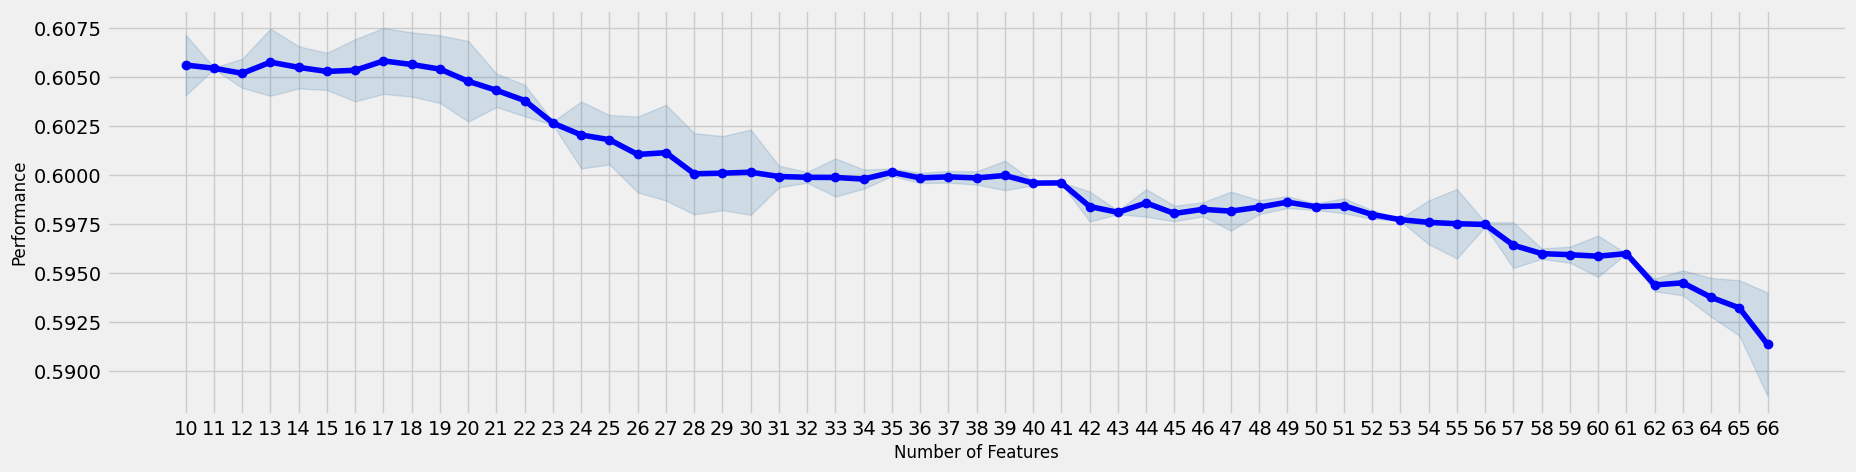

In [153]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig_sbs_std_dev = plot_sfs(sbs.get_metric_dict(), kind='std_dev', figsize=(20, 5))

In [ ]:
# 4.2 Отбор признаков при помощи метода номер 2

In [113]:
sfs = SequentialFeatureSelector(model,
                                k_features=10,
                                forward=True,
                                floating=False,
                                scoring='r2',
                                cv=2,
                                n_jobs=-1)

In [114]:
X_train

,poly__kitchen_area,poly__living_area,poly__total_area,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area ceiling_height,poly__total_area^2,poly__total_area ceiling_height,poly__ceiling_height^2,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,afc__kitchen_area,afc__living_area,afc__total_area,afc__house_age,afc__ceiling_height,afc__1/house_age,afc__house_age/total_area,afc__house_age*total_area,afc__living_area/house_age,afc__house_age*living_area,afc__living_area/total_area,afc__kitchen_area/house_age,afc__house_age*kitchen_area,afc__kitchen_area/total_area,afc__kitchen_area*total_area,afc__kitchen_area*living_area,afc__total_area*log(house_age),afc__kitchen_area*log(house_age),afc__sqrt(living_area)/total_area,afc__ceiling_height*log(total_area),afc__log(total_area)/ceiling_height,afc__log(ceiling_height)/ceiling_height,tail_scaler__flats_count,tail_scaler__floors_total,tail_scaler__floor,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__is_apartment_true,ohe__has_elevator_true,kbins__house_age,kbins__ceiling_height
0,0.604135,-0.596618,-0.728389,0.076830,0.509595,-0.304977,-0.158643,0.578627,-0.710115,-0.634057,-0.579869,-0.689013,-0.685270,0.050979,-0.287087,-0.754882,0.458936,0.546145,-0.209269,-0.062781,0.765381,-0.358154,-0.695527,-0.170490,0.484522,0.792940,-0.689016,-0.626947,-0.142357,-0.439541,-0.378547,0.832844,-0.161329,-0.360336,0.604135,-0.596618,-0.728389,0.183837,0.076830,-0.443960,0.405114,-0.228604,-0.495174,-0.340165,-0.263419,-0.292700,0.819429,1.279637,-0.158643,-0.304977,-0.471999,1.028939,0.296464,-0.510048,-0.755627,0.713079,-0.835320,0.553938,1.341618,0.328620,6.0,1.0,0.0,1.0,1.0,2.0
1,-0.512841,1.185079,0.652059,-1.434031,-0.682262,0.341250,-0.098742,-0.642461,1.196121,0.926627,0.937263,0.480448,0.347448,-1.370664,-0.234815,0.526513,0.290373,-0.761603,-0.261068,-0.515847,-1.314718,0.814145,1.238901,-0.103227,-0.861592,-0.822217,1.181185,0.281035,-0.142357,2.383102,1.909024,-1.538849,-0.790919,-0.360336,-0.512841,1.185079,0.652059,0.388187,-1.434031,-0.493798,-0.208011,0.866173,-0.102226,1.222866,0.957037,-0.496608,0.072193,-0.925045,-0.098742,0.341250,1.034233,-0.240654,0.235797,-0.146185,1.747029,-1.483043,1.039756,-0.217492,-1.045969,-1.203704,4.0,3.0,0.0,1.0,1.0,0.0
2,0.472726,-0.610219,-0.668370,0.379002,0.344036,-0.361772,-0.182906,0.497686,-0.718682,-0.625983,-0.574656,-0.649028,-0.594725,0.348430,-0.287087,-0.648144,0.553681,0.344727,-0.241712,-0.049121,0.782293,-0.379977,-0.700429,-0.170490,0.352115,0.725838,-0.579181,-0.607298,-0.142357,-0.448897,-0.780377,0.910515,0.136600,-0.360315,0.472726,-0.610219,-0.668370,-1.553138,0.379002,1.768299,-1.189328,-1.420420,0.749813,-1.114627,-0.346289,1.553350,-1.323728,1.038982,-0.182906,-0.361772,-1.459053,-0.689929,0.209930,-0.313226,-0.849655,0.707936,0.677526,0.746795,1.124565,0.147619,4.0,1.0,0.0,1.0,0.0,2.0
3,0.604135,0.695452,0.093878,-0.376428,0.509595,0.828545,0.360753,0.508851,0.517236,0.323316,0.625477,-0.055317,0.019232,-0.386996,-0.287087,-0.754882,0.458936,0.546145,-0.209269,-0.515773,-0.880577,0.960163,0.402597,-0.170490,-0.662261,-0.178066,0.633362,-0.214752,-0.142357,-0.261803,0.328610,0.382739,-0.480386,-0.360336,0.604135,0.695452,0.093878,-0.684651,-0.376428,-0.061069,-0.696061,-0.514252,0.275600,-0.135730,0.907580,0.043833,-0.240922,0.311467,0.360753,0.828545,-0.071175,0.505429,0.

In [115]:
sfs.fit(X_train, y_train)

/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovem

SequentialFeatureSelector(cv=2,
                          estimator=DecisionTreeRegressor(max_depth=10,
                                                          random_state=42),
                          k_features=(10, 10), n_jobs=-1, scoring='r2')

In [116]:
# Посмотрим лучшие фичи по мнению sfs
selected_feature_sfs = sfs.k_feature_idx_
selected_feature_sfs

(3, 12, 25, 27, 39, 57, 59, 60, 62, 63)

In [117]:
# Данные на лучших фичах по мнению sfs
X_train.iloc[:, list(selected_feature_sfs)]

,poly__ceiling_height,poly__total_area ceiling_height,spline__total_area_sp_1,spline__total_area_sp_3,afc__1/house_age,tail_scaler__floors_total,tail_scaler__distance_to_center,category_encoder__building_type_int,ohe__is_apartment_true,ohe__has_elevator_true
0,0.076830,-0.685270,0.792940,-0.626947,-0.443960,0.553938,0.328620,6.0,0.0,1.0
1,-1.434031,0.347448,-0.822217,0.281035,-0.493798,-0.217492,-1.203704,4.0,0.0,1.0
2,0.379002,-0.594725,0.725838,-0.607298,1.768299,0.746795,0.147619,4.0,0.0,1.0
3,-0.376428,0.019232,-0.178066,-0.214752,-0.061069,0.168223,1.102096,4.0,0.0,1.0
4,0.076830,-0.966920,1.110169,-0.705321,1.768299,1.132510,1.366460,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
75018,-0.376428,-1.076827,1.180875,-0.719661,-0.535818,0.168223,0.152645,6.0,0.0,1.0
75019,-1.585117,-0.454943,0.234152,-0.426453,-0.504959,-0.217492,1.377817,4.0,0.0,1.0
75020,0.076830,0.908871,-1.147326,0.660401,2.567687,1.711082,0.060068,2.0,0.0,1.0
75021,-1.585117,-1.075825,1.049495,-0.692125,-0.190200,0.553938,0.851866,4.0,0.0,1.0


In [122]:
# !!!!!! странно отображение метрики, не совсем понятно почему такое



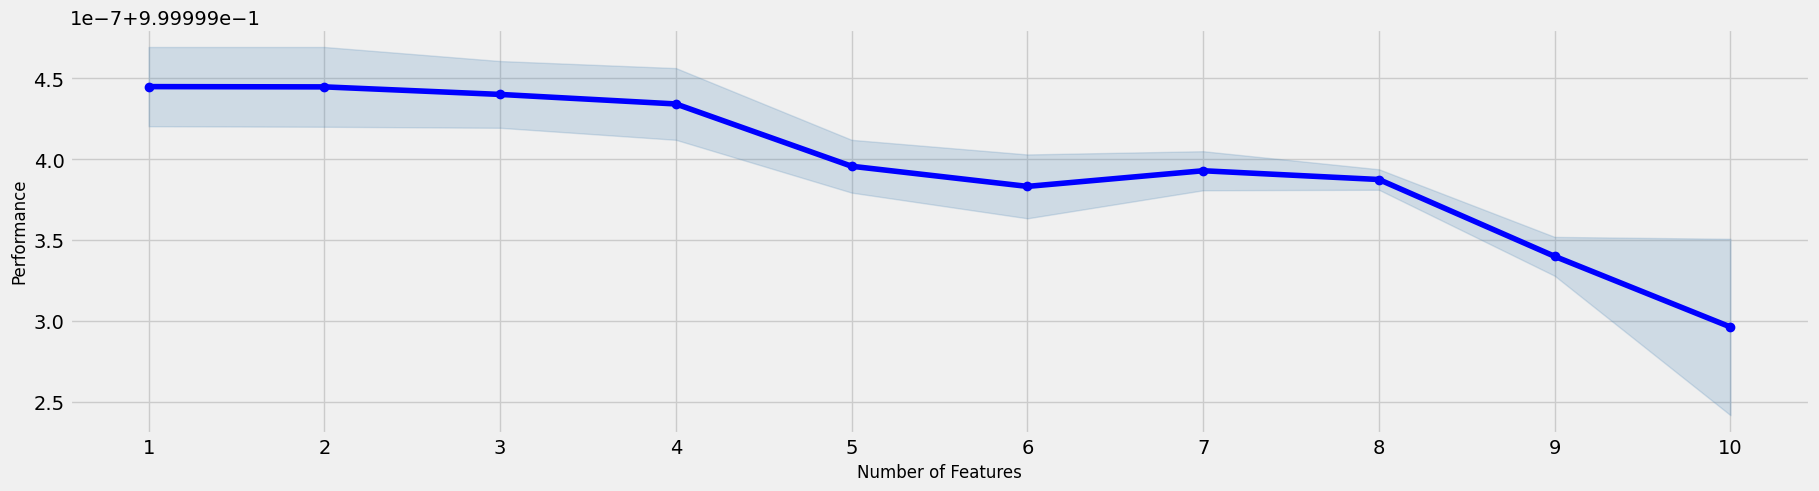

In [100]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig_sfs_std_dev = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(20, 5))

In [120]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели
# Используем объединение признаков
selected_features = list(set(selected_feature_sfs) | set(selected_feature_sbs))
selected_features

[1, 3, 12, 22, 25, 27, 31, 33, 37, 39, 57, 59, 60, 62, 63]

In [121]:
# Данные на лучших фичах
X_train.iloc[:, selected_features]

,poly__living_area,poly__ceiling_height,poly__total_area ceiling_height,spline__living_area_sp_3,spline__total_area_sp_1,spline__total_area_sp_3,spline__ceiling_height_sp_2,spline__ceiling_height_sp_4,afc__house_age,afc__1/house_age,tail_scaler__floors_total,tail_scaler__distance_to_center,category_encoder__building_type_int,ohe__is_apartment_true,ohe__has_elevator_true
0,-0.596618,0.076830,-0.685270,-0.695527,0.792940,-0.626947,0.832844,-0.360336,0.183837,-0.443960,0.553938,0.328620,6.0,0.0,1.0
1,1.185079,-1.434031,0.347448,1.238901,-0.822217,0.281035,-1.538849,-0.360336,0.388187,-0.493798,-0.217492,-1.203704,4.0,0.0,1.0
2,-0.610219,0.379002,-0.594725,-0.700429,0.725838,-0.607298,0.910515,-0.360315,-1.553138,1.768299,0.746795,0.147619,4.0,0.0,1.0
3,0.695452,-0.376428,0.019232,0.402597,-0.178066,-0.214752,0.382739,-0.360336,-0.684651,-0.061069,0.168223,1.102096,4.0,0.0,1.0
4,-0.324603,0.076830,-0.966920,-0.574125,1.110169,-0.705321,0.832844,-0.360336,-1.553138,1.768299,1.132510,1.366460,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75018,-0.644221,-0.376428,-1.076827,-0.712235,1.180875,-0.719661,0.382739,-0.360336,0.592537,-0.535818,0.168223,0.152645,6.0,0.0,1.0
75019,0.423437,-1.585117,-0.454943,0.046536,0.234152,-0.426453,-1.841114,-0.360336,0.439274,-0.504959,-0.217492,1.377817,4.0,0.0,1.0
75020,0.518643,0.076830,0.908871,0.162216,-1.147326,0.660401,0.832844,-0.360336,-1.655313,2.567687,1.711082,0.060068,2.0,0.0,1.0
75021,-0.528614,-1.585117,-1.075825,-0.669431,1.049495,-0.692125,-1.841114,-0.360336,-0.480301,-0.190200,0.553938,0.851866,4.0,0.0,1.0


In [ ]:
# 4.4 Обучение новой версии модели

In [ ]:
# 4.5 Логирование всех артефактов в MLflow

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [ ]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1

In [ ]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2

In [ ]:
# 5.3 Формирование списка гиперпараметров для новой модели

In [ ]:
# 5.4 Обуение финальной версии модели

In [ ]:
# 5.5 Логирование артефактов в MLflow